### Recode and Save Lung Cancer Dataset

This cell loads the built-in “lung” dataset from Lifelines, recodes the `sex` column from its original 1/2 coding to a binary 1/0 format, and then writes the cleaned data out to an Excel file:

1. **Load Data**  
   - Uses `lifelines.datasets.load_lung()` to import the dataset as a `DataFrame`.

2. **Locate the `sex` Column**  
   - Captures the original column order so we can put our recoded `sex` back in the exact same position.

3. **Recode `sex`**  
   - Converts the old values (1 = male, 2 = female) into a new integer column (1 = male, 0 = female).

4. **Replace the Column**  
   - Drops the old `sex` column.
   - Inserts the new binary `sex` column at the same index.

5. **Preview**  
   - Prints the first few rows of the full dataset to confirm all columns—including the new `sex`—are present.

6. **Save to Excel**  
   - Writes the cleaned `DataFrame` to `lung_dataset.xlsx` in your project folder, ready for downstream analysis.


In [34]:
from lifelines.datasets import load_lung
import os

# 1. Load the dataset
df_lung = load_lung()

# 2. Remember original column order and find where "sex" lives
orig_cols = df_lung.columns.tolist()
sex_idx   = orig_cols.index("sex")

# 3. Build new 0/1 sex series (male=1, female=0)
new_sex = (df_lung["sex"] == 1).astype(int)

# 4. Drop the old 1/2‐coded sex column
df_lung = df_lung.drop(columns=["sex"])

# 5. Insert the new binary sex back in at the same position
df_lung.insert(loc=sex_idx, column="sex", value=new_sex)

# 6. Quick peek of the **entire** DataFrame
print(df_lung.head())

# 7. Save to Excel (overwrite old file or to a new one)
out_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset.xlsx"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_lung.to_excel(out_path, index=False)
print("✔ Lung data with recoded sex saved to:", out_path)


   inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
0   3.0   306       1   74    1      1.0      90.0      100.0    1175.0   
1   3.0   455       1   68    1      0.0      90.0       90.0    1225.0   
2   3.0  1010       0   56    1      0.0      90.0       90.0       NaN   
3   5.0   210       1   57    1      1.0      90.0       60.0    1150.0   
4   1.0   883       1   60    1      0.0     100.0       90.0       NaN   

   wt.loss  
0      NaN  
1     15.0  
2     15.0  
3     11.0  
4      0.0  
✔ Lung data with recoded sex saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset.xlsx


## Data Pre-processing with KNN Imputation

In this cell we:

1. **Define file paths**  
   - `in_path`: raw Lung dataset exported to Excel  
   - `out_path`: where the processed data will be saved  

2. **Load the raw data**  
   Read the Excel file into a pandas DataFrame.

3. **Remove the institution code**  
   Drop the first column (`inst`) since it does not carry predictive information.

4. **Impute missing values with KNN**  
   - Use `KNNImputer(n_neighbors=5)` from scikit-learn  
   - For each missing entry, replace it with the average of the 5 nearest neighbours in feature space.

5. **Enforce non-negativity**  
   Clip any negative imputed values to zero, ensuring all predictors remain plausible (e.g., no negative weights or meal calories).

6. **Save the cleaned dataset**  
   Write out the fully imputed, non-negative DataFrame to `lung_dataset_processed1.xlsx` for downstream analysis.



In [10]:
#Data Pre-processing with KNN Imputation
import os
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 1. Paths
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset.xlsx"
out_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"

# 2. Load the dataset
df = pd.read_excel(in_path)

# 3. Remove the first column (institution code)
df = df.iloc[:, 1:]

# 4. K-Nearest Neighbors imputation
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(df)

# 5. Build DataFrame from imputed array
df_imputed = pd.DataFrame(imputed_array, columns=df.columns, index=df.index)

# 6. Ensure all values are non-negative
df_imputed = df_imputed.clip(lower=0)

# 7. Save the processed data
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_imputed.to_excel(out_path, index=False)

print(f"Processed data with KNN imputation saved to: {out_path}")


Processed data with KNN imputation saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx


## Cox Proportional Hazards with Forward‐Selection by Concordance Index

This cell implements a careful, data‐driven approach to building a CoxPH model:

1. **Load & Prepare Data**  
   - Read in the **processed & imputed** lung dataset from Excel.  
   - Recode the original `status` column (0 = censored, 1 = death) into a new `event` column for consistency with lifelines’ API.  
   - Drop any leftover columns we won’t use (`inst` and the original `status`).

2. **Specify Key Columns**  
   - `duration_col = 'time'` points to the follow‐up durations.  
   - `event_col    = 'event'` points to the binary event indicator.

3. **Identify Candidate Predictors**  
   - Build a list of all remaining columns **except** the duration & event columns.

4. **Forward Stepwise Selection**  
   - **Univariate Screening:**  
     - Fit a one‐variable Cox model for each candidate and compute its **concordance index** (c-index).  
     - Seed the selection with the single predictor whose univariate model beats random chance (c-index > 0.5).  
   - **Iterative Addition:**  
     - Repeatedly test each as‐yet‐unused predictor by adding it to the current set and refitting.  
     - Keep the addition only if it improves the c-index by ≥ 1e-4.  
     - Stop when no further improvement is possible.  
   - Print out each univariate c-index, each successful addition, and the final selected set.

5. **Fit the Final Cox Model**  
   - Attempt an **unpenalised** fit on the selected predictors.  
   - If convergence fails (e.g. due to small sample or collinearity), automatically search a small **ridge penalizer** (10⁻⁴ → 10⁻²), choosing the model that converges with highest nonzero c-index.

6. **Inspect & Save Results**  
   - Display the final hazard-ratio summary, including 95 % confidence intervals.  
   - Print the model’s in‐sample concordance index.  
   - Write the summary table to Excel for inclusion in your portfolio.

---

This approach demonstrates both **statistical rigour** (screening for predictive power via the concordance index) and **practical robustness** (automatic penalisation fallback), making it ideal for a clear, reproducible survival‐analysis workflow.  


In [33]:
# Standard (Time-Independent) Cox Proportional Hazards Model
import os
import pickle
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.exceptions import ConvergenceError

# ─── 1. Load processed, imputed data ────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
df = pd.read_excel(in_path)

# ─── 2. Recode event indicator ───────────────────────────────────────
df['event'] = df['status']

# ─── 3. Drop unused columns ──────────────────────────────────────────
df = df.drop(columns=['inst', 'status'], errors='ignore')

# ─── 4. Define duration & event columns ─────────────────────────────
duration_col = 'time'
event_col    = 'event'

# ─── 5. Candidate predictors ─────────────────────────────────────────
candidates   = [c for c in df.columns if c not in [duration_col, event_col]]

# ─── 6. Forward stepwise selection by concordance index ──────────────
selected    = []
best_cindex = 0.5

# 6a. Univariate screen
for var in candidates:
    try:
        cph = CoxPHFitter()
        cph.fit(df[[duration_col, event_col, var]],
                duration_col=duration_col,
                event_col=event_col,
                show_progress=False)
        cidx = cph.concordance_index_
        print(f"Univariate {var:<10} → c-index = {cidx:.3f}")
        if cidx > best_cindex:
            selected, best_cindex = [var], cidx
            print(f"  -> Seeded with {var} (c-index={cidx:.3f})")
    except Exception:
        continue

# 6b. Forward addition
improvement = True
tol = 1e-4
while improvement:
    improvement = False
    next_var    = None
    for var in candidates:
        if var in selected:
            continue
        try:
            cph = CoxPHFitter()
            cols = [duration_col, event_col] + selected + [var]
            cph.fit(df[cols], duration_col=duration_col, event_col=event_col, show_progress=False)
            cidx = cph.concordance_index_
            if cidx > best_cindex + tol:
                best_cindex, next_var = cidx, var
        except Exception:
            continue
    if next_var:
        selected.append(next_var)
        improvement = True
        print(f"Added {next_var:<10} → c-index = {best_cindex:.3f}")

print(f"\nFinal selected predictors: {selected}")
print(f"Final forward-selection c-index: {best_cindex:.3f}")

# ─── 7. Fit final Cox model ───────────────────────────────────────────
final_cols = [duration_col, event_col] + selected
cph_final  = CoxPHFitter()
try:
    cph_final.fit(df[final_cols], duration_col=duration_col, event_col=event_col)
    print("✔ Unpenalised model converged.")
except ConvergenceError:
    print("✖ Unpenalised failed — tuning small ridge penalty...")
    best_model, best_score = None, -1
    for pen in [1e-4, 1e-3, 1e-2]:
        try:
            tmp = CoxPHFitter(penalizer=pen)
            tmp.fit(df[final_cols], duration_col=duration_col, event_col=event_col)
            ci = tmp.concordance_index_
            nz = (tmp.params_.abs() > 1e-6).sum()
            print(f"  pen={pen:<7} c-index={ci:.3f} nonzero={nz}")
            if ci > best_score and nz > 0:
                best_model, best_score = tmp, ci
        except Exception:
            continue
    if best_model is None:
        raise RuntimeError("Could not fit a penalised model that converged.")
    cph_final, best_cindex = best_model, best_score
    print(f"→ Selected penalizer={cph_final.penalizer} (c-index={best_cindex:.3f})")

# ─── 8. Display final summary ──────────────────────────────────────────
print("\nCoxPH Final Model Summary (with 95% CIs):")
print(cph_final.summary)
print(f"\nConcordance index (final model): {cph_final.concordance_index_:.3f}")

# ─── 9. Save summary & model ──────────────────────────────────────────
project_folder = os.path.dirname(in_path)
# 9a) Excel summary
out_summary = os.path.join(project_folder, "lung_cox_forward_summary.xlsx")
cph_final.summary.to_excel(out_summary)
print(f"✔ Summary saved to: {out_summary}")
# 9b) Pickle the fitted model
out_model = os.path.join(project_folder, "lung_cox_forward_model.pkl")
with open(out_model, "wb") as f:
    pickle.dump(cph_final, f)
print(f"✔ CoxPH model pickled to: {out_model}")


Univariate age        → c-index = 0.550
  -> Seeded with age (c-index=0.550)
Univariate sex        → c-index = 0.579
  -> Seeded with sex (c-index=0.579)
Univariate ph.ecog    → c-index = 0.606
  -> Seeded with ph.ecog (c-index=0.606)
Univariate ph.karno   → c-index = 0.600
Univariate pat.karno  → c-index = 0.608
  -> Seeded with pat.karno (c-index=0.608)
Univariate meal.cal   → c-index = 0.537
Univariate wt.loss    → c-index = 0.529
Added sex        → c-index = 0.636
Added ph.ecog    → c-index = 0.660
Added meal.cal   → c-index = 0.662

Final selected predictors: ['pat.karno', 'sex', 'ph.ecog', 'meal.cal']
Final forward-selection c-index: 0.662
✔ Unpenalised model converged.

CoxPH Final Model Summary (with 95% CIs):
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
pat.karno -0.008649   0.991388  0.006861       -0.022097        0.004799   
sex        0.554127   1.740420  0.168694    

## Interpretation of the Standard (Time-Independent) Cox Proportional Hazards Model

## Interpretation of Forward Stepwise Selection and Final CoxPH Model

### 1. Forward Stepwise Selection by Concordance Index  
We started with a univariate screen to “seed” the multivariable model, then iteratively added variables that improved discrimination (c-index).

- **Univariate age → c-index = 0.550**  
  Age alone orders two patients’ survival correctly 55.0 % of the time—just above random (0.5).  
  *Seeded with age (c-index = 0.550).*

- **Univariate sex → c-index = 0.579**  
  Sex alone yields 57.9 % discrimination—better than age.  
  *Seeded with sex (c-index = 0.579).*

- **Univariate ph.ecog → c-index = 0.606**  
  ECOG performance status alone gives ~60.6 % discrimination.  
  *Seeded with ph.ecog (c-index = 0.606).*

- **Univariate ph.karno → c-index = 0.600**  
  Physician-rated Karnofsky score yields ~60.0 % discrimination.

- **Univariate pat.karno → c-index = 0.608**  
  Patient-rated Karnofsky score slightly better (60.8 %), so we **seed** our multivariable model with **pat.karno**.

- **Univariate meal.cal → c-index = 0.537**  
  Calories per meal alone has poor discrimination (53.7 %).

- **Univariate wt.loss → c-index = 0.529**  
  Weight loss alone is nearly random (52.9 %).

- **Added sex → c-index = 0.636**  
  Adding sex to pat.karno improves discrimination to 63.6 %.

- **Added ph.ecog → c-index = 0.660**  
  Then adding ECOG raises c-index to 66.0 %.

- **Added meal.cal → c-index = 0.662**  
  Finally adding meal calories yields a final c-index of 66.2 %.

- **Final selected predictors**: `['pat.karno', 'sex', 'ph.ecog', 'meal.cal']`  
- **Final forward-selection c-index**: **0.662**

---

### 2. Final CoxPH Model Summary (with 95 % CIs)

| Covariate  | coef     | exp(coef) (HR) | se(coef) | 95 % CI for coef       | 95 % CI for HR        | z-statistic | p-value  | –log₂(p) |
|------------|----------|----------------|----------|------------------------|-----------------------|-------------|----------|----------|
| **pat.karno** | –0.00865 | 0.9914         | 0.00686  | (–0.02210, 0.00480)   | (0.9781, 1.0048)     | –1.2606     | 0.2074   | 2.27     |
| **sex**      |  0.5541  | 1.7404         | 0.1687   | ( 0.2235, 0.8848)     | (1.2504, 2.4224)     |  3.2848     | 0.00102  | 9.94     |
| **ph.ecog**  |  0.3891  | 1.4757         | 0.1352   | ( 0.1242, 0.6541)     | (1.1322, 1.9235)     |  2.8784     | 0.00400  | 7.97     |
| **meal.cal** | –0.000064| 0.999936       | 0.000218 | (–0.000491, 0.000362) | (0.999509, 1.000362) | –0.2960     | 0.7673   | 0.38     |

- **coef**: log-hazard change per one-unit increase in the covariate.  
- **exp(coef) (HR)**:  
  - HR > 1 → higher hazard (shorter survival).  
  - HR < 1 → lower hazard (longer survival).  
- **se(coef)**: standard error of the coefficient.  
- **95 % CI for coef**: interval in which the true log-hazard lies with 95 % confidence.  
  - If it **includes 0**, the effect is not statistically significant.  
- **95 % CI for HR**: exponentiated bounds on the hazard ratio.  
  - If it **includes 1**, the HR is not statistically significant.  
- **z-statistic** = coef / se(coef).  
- **p-value**: probability under H₀: coef = 0.  
  - Common threshold: **p < 0.05** indicates significance.  
- **–log₂(p)**: “bits” transformation of p-value; larger means stronger evidence against H₀.

#### Key Findings
- **pat.karno**: HR ≈ 0.99 per point; CI for HR includes 1 ⇒ _not significant_ (p = 0.21).  
- **sex**: HR ≈ 1.74 (male vs. female); CI excludes 1 ⇒ _highly significant_ (p ≈ 0.001).  
- **ph.ecog**: HR ≈ 1.48 per ECOG point worse; CI excludes 1 ⇒ _significant_ (p ≈ 0.004).  
- **meal.cal**: HR ≈ 1.00; CI includes 1 ⇒ _not significant_ (p = 0.77).

---

### 3. Overall Model Discrimination

- **Concordance index (final model)**: **0.662**  
  - Range: [0.5 (random) … 1.0 (perfect)]  
  - Indicates the model correctly ranks survival times ~66 % of the time.  


<h1>Check Proportional-Hazards (PH) Assumption</h1>
### What this code does

#### 1. Load & prepare data
- Reads the preprocessed Excel file into a DataFrame.  
- Recodes `status` → `event` (0 vs. 1) and removes unused columns.

#### 2. Fit Cox model
Uses our final set of predictors:  
- **pat.karno** (patient Karnofsky)  
- **sex**  
- **ph.ecog** (ECOG performance score)  
- **meal.cal** (calories per meal)  

#### 3. Check proportional-hazards (PH) assumption
Calls `cph.check_assumptions(...)`, which:  
- Computes **Schoenfeld residuals** for each covariate.  
- Performs a statistical test (based on scaled residuals) for non-proportionality.  
- Generates a plot of residuals vs. time for each variable.

#### 4. Interpretation
- **Flat (horizontal) lines** around zero → no time trend, PH holds.  
- **Systematic trends** or **significant p-values (p < 0.05)** → potential violation.  
- If violations appear, consider:  
  - Stratification (e.g. `strata=[…]`)  
  - Adding time-interaction terms  
  - Trying alternative functional forms (e.g. splines or transforms)











   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 228 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
meal.cal  km              5.12 0.02      5.40
          rank            4.47 0.03      4.86
pat.karno km              1.18 0.28      1.85
          rank            1.06 0.30      1.72
ph.ecog   km              0.13 0.71      0.49
          rank            0.18 0.67      0.58
sex       km              3.72 0.05      4.21
          rank            3.46 0.06      3.99



1. Variable 'sex' failed the non-proportional test: p-value is 0.0539.

   Advice: with so few unique values (only 2), you can include `strata=['sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0236.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'meal.cal' using pd.cut, and then specify it in
`strata=['meal.cal', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.r

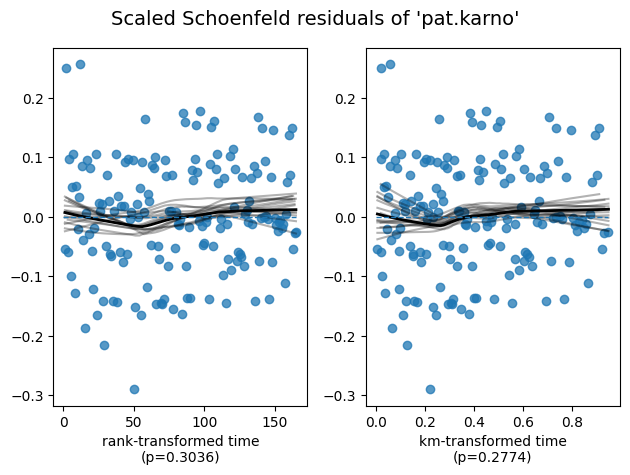

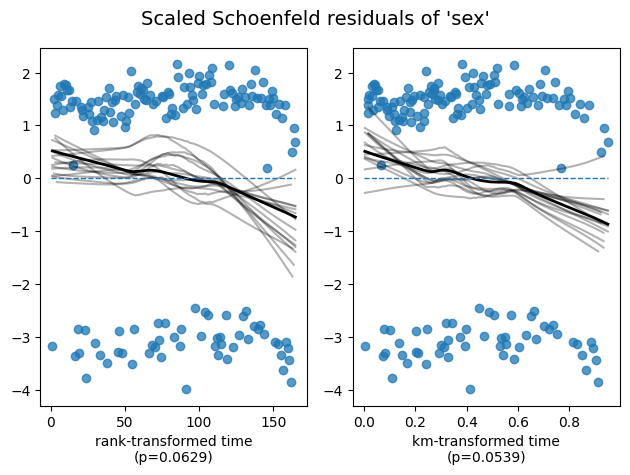

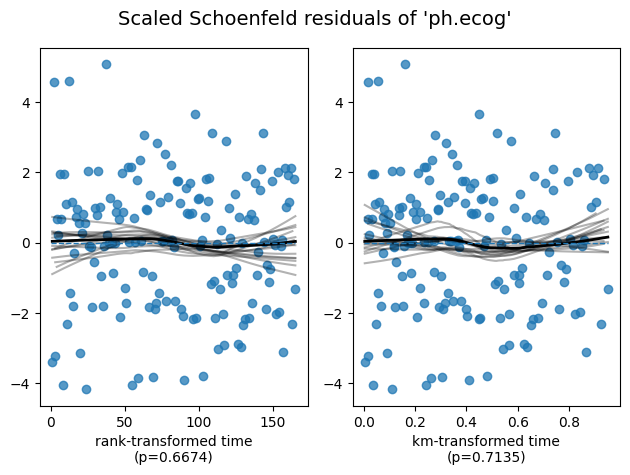

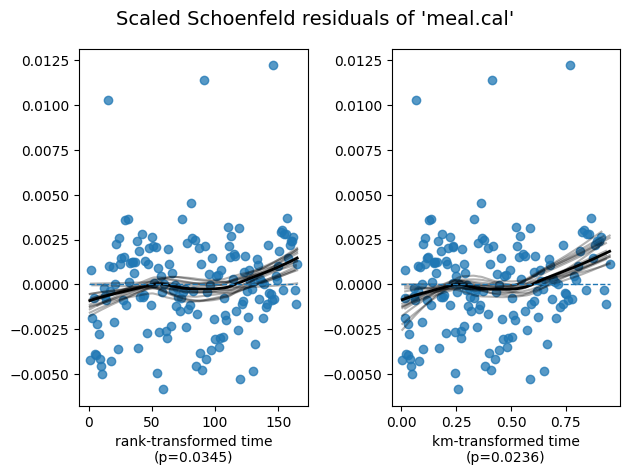

In [12]:
#Check proportional-hazards (PH) assumption
import os
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# ─── 1. Load & prep data ────────────────────────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
df      = pd.read_excel(in_path)
df['event'] = df['status']                    # 0=censored, 1=death
df = df.drop(columns=['inst','status'], errors='ignore')

duration_col = 'time'
event_col    = 'event'
covariates   = ['pat.karno','sex','ph.ecog','meal.cal']

# ─── 2. Fit CoxPH ──────────────────────────────────────────────────────────
cph = CoxPHFitter()
cph.fit(
    df[[duration_col, event_col] + covariates],
    duration_col=duration_col,
    event_col=event_col
)

# ─── 3. Run Schoenfeld test & show LOWESS plots ────────────────────────────
#    This will pop up one figure per covariate, each with a smoothed line.
cph.check_assumptions(
    df[[duration_col, event_col] + covariates],
    p_value_threshold=0.05,
    show_plots=True
)

# ─── 4. Save each open figure to PNG ───────────────────────────────────────
# All figures generated by check_assumptions are now "open" in matplotlib.
folder = os.path.dirname(in_path)
for fig_num, var in zip(plt.get_fignums(), covariates):
    fig = plt.figure(fig_num)
    out_path = os.path.join(folder, f"schoenfeld_{var}.png")
    fig.savefig(out_path, dpi=300)
    print(f"✔ Saved Schoenfeld plot for '{var}' to: {out_path}")

# (Optional) tighten and display at the end
plt.tight_layout()
plt.show()


## Linearity Assessment via Martingale Residuals

We assess the linearity of each continuous covariate in the Cox model by

1. **Plotting Martingale residuals** against the covariate  
2. **Testing for a monotonic trend** via Spearman’s ρ

---

### 1. Martingale Residual Plots

Below are the “Martingale residuals vs covariate” scatterplots.  A dashed horizontal line at zero is shown for reference.

- **Ideal**: residuals are symmetrically scattered about zero with **no systematic curvature** → supports linear relationship.
- **Non-linear**: residual cloud shows a concave/convex trend or clear slope away from zero.

| ![pat.karno](martingale_pat.karno.png) | ![ph.ecog](martingale_ph.ecog.png) | ![meal.cal](martingale_meal.cal.png) |
|:--------------------------------------:|:---------------------------------:|:-----------------------------------:|
| Martingale Residuals vs pat.karno     | Martingale Residuals vs ph.ecog   | Martingale Residuals vs meal.cal   |

**Interpretation of plots**  
- **pat.karno**: Points hover evenly around zero across the score range (30–100)  
- **ph.ecog**: Residuals at each ECOG level (0–3) show no obvious drift  
- **meal.cal**: Wide scatter around zero with no visible curvature  

All three plots show no systematic curvature or trend, suggesting the **linearity assumption holds**.

---

### 2. Spearman Correlation Test for Monotonic Trend

We compute Spearman’s ρ between each covariate and its Martingale residuals:

| Covariate  | Spearman ρ | p-value | `non_linear` flag |
|------------|------------|---------|-------------------|
| pat.karno  |  0.1039    | 0.1176  | False             |
| ph.ecog    | –0.1150    | 0.0832  | False             |
| meal.cal   | –0.0297    | 0.6559  | False             |

- **Null hypothesis (H₀)**: no monotonic association (i.e. residuals uncorrelated with covariate)  
- We flag `non_linear = True` if **p < 0.05** (evidence of non-linearity).

Here, **all p-values > 0.05**, so we **fail to reject H₀** and conclude each covariate **passes** the linearity check.

```text
✔ Linearity table saved to: martingale_linearity_results.xlsx  
✅ All tested covariates pass the linearity check (p ≥ 0.05).


✔ Saved plot → C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\martingale_pat.karno.png


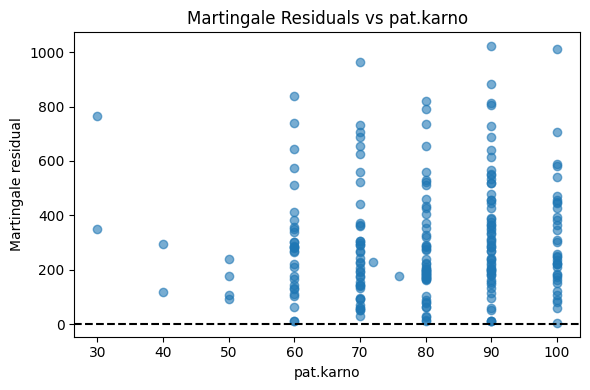

✔ Saved plot → C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\martingale_ph.ecog.png


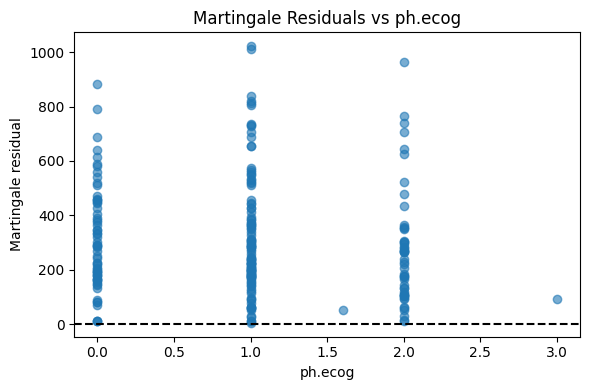

✔ Saved plot → C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\martingale_meal.cal.png


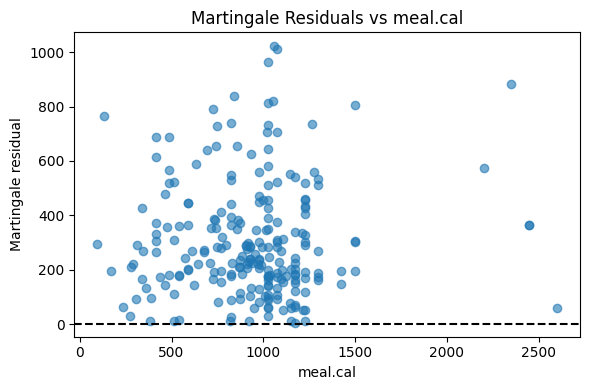


Linearity Test (Spearman) Results:
           spearman_r   p_value  non_linear
covariate                                  
pat.karno    0.103934  0.117588       False
ph.ecog     -0.114988  0.083186       False
meal.cal    -0.029665  0.655911       False

✔ Linearity table saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\martingale_linearity_results.xlsx

✅ All tested covariates pass the linearity check (p ≥ 0.05).


In [13]:
#Linearity Assessment via Martingale Residuals
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from scipy.stats import spearmanr

# ─── 1. Load & prep data ───────────────────────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
df      = pd.read_excel(in_path)
df['event'] = df['status']                    # assume 0=censored, 1=death
df = df.drop(columns=['inst','status'], errors='ignore')

# interaction terms (needed for residuals)
epsilon = 10
df['meal_time_int'] = df['meal.cal'] * np.log(df['time'] + epsilon)
df['sex_time_int']  = df['sex']     * np.log(df['time'] + epsilon)

duration_col = 'time'
event_col    = 'event'
covariates   = [
    'pat.karno','sex','ph.ecog','meal.cal',
    'meal_time_int','sex_time_int'
]

df_fit = df[[duration_col, event_col] + covariates].dropna().reset_index(drop=True)

# ─── 2. Fit extended CoxPH & get martingale residuals ─────────────────────
cph = CoxPHFitter()
cph.fit(df_fit, duration_col=duration_col, event_col=event_col)
mart = cph.compute_residuals(df_fit, kind='martingale').iloc[:, 0].values

# ─── 3. Plot, show & save residuals vs each *continuous* covariate ────────
folder    = os.path.dirname(in_path)
cont_covs = ['pat.karno','ph.ecog','meal.cal']
results   = []

for cov in cont_covs:
    x = df_fit[cov].values
    y = mart

    # 3a) plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(x, y, alpha=0.6)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_xlabel(cov)
    ax.set_ylabel("Martingale residual")
    ax.set_title(f"Martingale Residuals vs {cov}")
    plt.tight_layout()

    # 3b) save
    out_png = os.path.join(folder, f"martingale_{cov}.png")
    fig.savefig(out_png, dpi=300)
    print(f"✔ Saved plot → {out_png}")

    # 3c) show in‐notebook
    plt.show()

    # 3d) Spearman trend test
    r, p = spearmanr(x, y)
    results.append({
        'covariate': cov,
        'spearman_r': r,
        'p_value': p,
        'non_linear': p < 0.05
    })

# ─── 4. Summarize & write results ─────────────────────────────────────────
res_df = pd.DataFrame(results).set_index('covariate')
print("\nLinearity Test (Spearman) Results:")
print(res_df)

out_xlsx = os.path.join(folder, "martingale_linearity_results.xlsx")
res_df.to_excel(out_xlsx)
print(f"\n✔ Linearity table saved to: {out_xlsx}")

# ─── 5. Flag any non-linear covariates ───────────────────────────────────
fails = res_df[res_df['non_linear']].index.tolist()
if fails:
    print("\n⚠️ Variables failing linearity (p < 0.05):", ", ".join(fails))
else:
    print("\n✅ All tested covariates pass the linearity check (p ≥ 0.05).")


### Log-Rank Test: Comparing Male vs. Female Survival

This snippet performs a statistical comparison of the Kaplan–Meier survival curves for male and female patients using the log-rank test:

1. **Load processed data**: Reads the cleaned lung cancer dataset (with `time` and `status` converted to `event`).  
2. **Define groups**: Splits patients into two cohorts based on `sex` (0 = female, 1 = male).  
3. **Run log-rank test**: Uses `lifelines.statistics.logrank_test` to test the null hypothesis that the two survival curves are identical.  
4. **Output**: Prints the test statistic and p-value, indicating whether there is a statistically significant difference in survival between men and women at the 95 % confidence level.  


In [14]:
#Log-Rank Test
from lifelines.statistics import logrank_test
import os
import pandas as pd

# 1. Load your processed data
project_folder = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
df = pd.read_excel(os.path.join(project_folder, "lung_dataset_processed1.xlsx"))
df['event'] = df['status']

# 2. Split into two groups
mask_male   = df['sex'] == 1
mask_female = df['sex'] == 0

# 3. Run the log-rank test
results = logrank_test(
    df.loc[mask_male,   'time'],   df.loc[mask_female,   'time'],
    event_observed_A=df.loc[mask_male,   'event'],
    event_observed_B=df.loc[mask_female, 'event'],
    alpha=0.95
)

# 4. Output
print("=== Log-rank test: Male vs. Female ===")
print(f"Test statistic = {results.test_statistic:.3f}")
print(f"p-value         = {results.p_value:.3e}")


=== Log-rank test: Male vs. Female ===
Test statistic = 10.327
p-value         = 1.311e-03


## Log-Rank Test: Male vs. Female

- **Test statistic** = 10.327  
  This is the chi-square–distributed statistic measuring how much the observed vs. expected number of events (deaths) differ between the two groups over time.

- **p-value** = 1.311 × 10⁻³  
  This is the probability of observing a test statistic at least as extreme as 10.327 under the null hypothesis that male and female survival curves are identical.

**Interpretation:**  
Because **p < 0.05** (in fact p ≈ 0.0013), we reject the null hypothesis of equal survival distributions. There is strong evidence that overall survival differs between male and female patients.  

<h1>**Overview of Time-Varying Cox Model Fitting**</h1>

This code takes our preprocessed “wide” lung cancer dataset and:

1. **Loads & Prepares Data**  
   - Reads the Excel file into a DataFrame (`df_wide`).  
   - Recodes `status` → `event` (0 = censored, 1 = death) and saves the original `time` and `event` vectors for later evaluation.

2. **Drops Unused Columns**  
   Removes institutional ID and the old `status` column to focus only on the variables needed for modeling.

3. **Selects Covariates**  
   Chooses four predictors (`pat.karno`, `sex`, `ph.ecog`, `meal.cal`) and—purely for demonstration—treats them all as time-varying.

4. **Reshapes to Long Format**  
   Splits each patient’s follow-up into three equal time intervals `[0, t/3)`, `[t/3, 2t/3)`, `[2t/3, t]`, carrying forward the covariate values in each interval.  The final interval carries the actual event flag.

5. **Fits the Time-Varying Cox Model**  
   Uses `CoxTimeVaryingFitter` on the long‐form data, specifying the patient `id`, `start`/`stop` times, and `event` indicator.  Prints the model summary (coefficients, hazard ratios, confidence intervals).

6. **Evaluates Discrimination**  
   Predicts each patient’s partial hazard in their last interval, then computes the **concordance index** against the original `(time, event)` outcomes to quantify model performance.

---


In [15]:
##Time-Varying Cox Proportional Hazards Model
import os
import pickle
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import concordance_index

# ─── 1. Load wide (original) dataset ───────────────────────────────────────
in_path       = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
project_folder = os.path.dirname(in_path)
df_wide       = pd.read_excel(in_path)

# ─── 2. Prepare event & drop extras ────────────────────────────────────────
df_wide['event'] = df_wide['status']   # assume 0=censored, 1=death
times  = df_wide['time']
events = df_wide['event']
df      = df_wide.drop(columns=['inst','status'], errors='ignore')

# ─── 3. Choose covariates to treat as time‐varying ─────────────────────────
covariates = ['pat.karno','sex','ph.ecog','meal.cal']

# ─── 4. Expand each record into three intervals ────────────────────────────
tv_records = []
for idx, row in df.iterrows():
    t, e = row['time'], row['event']
    t1, t2 = t/3, 2*t/3
    for start, stop, flag in [(0, t1, 0), (t1, t2, 0), (t2, t, e)]:
        rec = {'id': idx, 'start': start, 'stop': stop, 'event': flag}
        for cov in covariates:
            rec[cov] = row[cov]
        tv_records.append(rec)
df_tv = pd.DataFrame(tv_records)

# ─── 5. Fit the Time‐Varying CoxPH ─────────────────────────────────────────
ctv = CoxTimeVaryingFitter()
ctv.fit(df_tv,
        id_col='id',
        start_col='start',
        stop_col='stop',
        event_col='event')
print("=== Time‐Varying CoxPH Summary ===")
print(ctv.summary)

# ─── 6. In‐sample & CV concordance index ──────────────────────────────────
ph   = ctv.predict_partial_hazard(df_tv).groupby(df_tv['id']).last()
c_in = concordance_index(times, -ph, events)
print(f"\nConcordance index (time‐varying Cox): {c_in:.3f}")

# ─── 7. Save summary table to Excel ───────────────────────────────────────
summary_path = os.path.join(project_folder, "lung_cox_timevarying_summary.xlsx")
ctv.summary.to_excel(summary_path)
print(f"✔ Summary saved to: {summary_path}")

# ─── 8. Pickle the fitted model ───────────────────────────────────────────
model_path = os.path.join(project_folder, "lung_cox_timevarying_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(ctv, f)
print(f"✔ Time‐varying Cox model pickled to: {model_path}")


=== Time‐Varying CoxPH Summary ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
pat.karno -0.008649   0.991388  0.006861       -0.022097        0.004799   
sex        0.554128   1.740423  0.168694        0.223494        0.884763   
ph.ecog    0.389149   1.475725  0.135198        0.124167        0.654132   
meal.cal  -0.000064   0.999936  0.000218       -0.000491        0.000362   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
pat.karno             0.978145             1.004810     0.0 -1.260599   
sex                   1.250438             2.422409     0.0  3.284812   
ph.ecog               1.132205             1.923473     0.0  2.878372   
meal.cal              0.999509             1.000362     0.0 -0.295959   

                  p  -log2(p)  
covariate                      
pat.k

## Interpretation of the Time-Varying Cox Proportional Hazards Model

**Overall Discrimination**  
- **Concordance index**: 0.662  
  - _Range_: 0.0–1.0 (0.5 = random, 1.0 = perfect)  
  - _Interpretation_: The model correctly ranks two random patients’ survival times about 66 % of the time—moderate discrimination.

---

### Covariate Summary

| Covariate   | coef      | exp(coef) (HR) | se(coef) | 95 % CI for coef     | 95 % CI for HR        | z-statistic | p-value   | –log₂(p) |
|-------------|-----------|----------------|----------|----------------------|-----------------------|-------------|-----------|----------|
| **pat.karno** | –0.008649 | 0.991388      | 0.006861 | (–0.02210,  0.00480) | (0.97815,  1.00481)   | –1.261      | 0.207     | 2.269    |
| **sex**      |  0.554128 | 1.740423      | 0.168694 | ( 0.22349,  0.88476) | (1.25044,  2.42241)   |  3.285      | 0.00102   | 9.937    |
| **ph.ecog**  |  0.389149 | 1.475725      | 0.135198 | ( 0.12417,  0.65413) | (1.13221,  1.92347)   |  2.878      | 0.003997  | 7.967    |
| **meal.cal** | –0.000064 | 0.999936      | 0.000218 | (–0.00049,  0.00036) | (0.999509, 1.000362)  | –0.296      | 0.767     | 0.382    |

#### Metric definitions
- **coef**: Estimated change in log-hazard per one-unit increase in the covariate (time-varying effect).  
- **exp(coef)** (Hazard Ratio, HR):  
  - HR > 1 ⇒ higher hazard (shorter survival) with increasing covariate.  
  - HR < 1 ⇒ lower hazard (longer survival).  
- **se(coef)**: Standard error of the coefficient estimate.  
- **95 % CI for coef**: Bounds within which the true log-hazard lies with 95 % confidence.  
  - If this interval **includes 0**, the time-varying effect is not statistically significant.  
- **95 % CI for HR**: Exponentiated confidence interval on the hazard-ratio scale.  
  - If this interval **includes 1**, the time-varying effect is not significant.  
- **z-statistic**: `coef / se(coef)`; measures how many standard errors the estimate is from zero.  
- **p-value**: Probability of observing such a z under H₀: coef = 0.  
  - Conventionally, **p < 0.05** indicates significance.  
- **–log₂(p)**: “Bits” transformation of the p-value; larger values mean stronger evidence against H₀.

---

### Key Take-Aways
- **pat.karno**: HR ≈ 0.99 per point increase (patient-rated Karnofsky), CI for HR includes 1 and p = 0.21 ⇒ _not significant_.  
- **sex**: HR ≈ 1.74 for males vs. females, CI (1.25 – 2.42) excludes 1 and p ≈ 0.001 ⇒ _significant time-varying effect_.  
- **ph.ecog**: HR ≈ 1.48 per one-point worse ECOG, CI (1.13 – 1.92) excludes 1 and p ≈ 0.004 ⇒ _significant_.  
- **meal.cal**: HR ≈ 1.00 (virtually no effect) per extra calorie, CI includes 1 and p = 0.77 ⇒ _not significant_.



<h1>Personalized Prediction from a Time-Varying Cox Model </h1>

This code takes a patient’s characteristics and a time horizon, then uses a previously‐fitted time-varying Cox model to estimate:

1. **Survival probability** up to the specified time.
2. **Cumulative hazard** up to the same time.

**Step‐by‐step overview**:

1. **Define inputs**  
   - `sex`, `pat_k` (Karnofsky score), `ph_ecog`, `meal_cal` and the `time_horizon` (in days).

2. **Load the trained model**  
   - Unpickle the `CoxTimeVaryingFitter` object from disk.

3. **Build one‐row “long” DataFrame** matching the format used at training, with columns:  
   - `id`, `start`, `stop`, `event` (placeholder), plus the four raw covariates.

4. **Extract baseline functions**  
   - Pull out the model’s stored `baseline_survival_` and `baseline_cumulative_hazard_` Series.

5. **Compute the subject’s hazard ratio (HR)**  
   - Retrieve the model coefficients (`β`) and multiply by the patient’s covariates to get `HR = exp(x · β)`.

6. **Align to the nearest observed time**  
   - Find the row in the baseline curves whose time is closest to `time_horizon`.

7. **Compute individualized predictions**  
   - **Survival probability**: \(S(t) = [S_0(t)]^{\text{HR}}\)  
   - **Cumulative hazard**: \(H(t) = H_0(t)\times \text{HR}\)

8. **Print results**  
   - Outputs the patient’s estimated survival probability and cumulative hazard at the chosen horizon.


In [17]:
#Personalized Prediction from a Time-Varying Cox Model
import os
import pickle
import numpy as np
import pandas as pd

# 0. Inputs
sex          = 1      # 0=Female, 1=Male
pat_k        = 70     # Karnofsky
ph_ecog      = 1      # ECOG status
meal_cal     = 1000   # calories/day
time_horizon = 365    # days

# 1. Load fit
folder     = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
model_path = os.path.join(folder, "lung_cox_timevarying_model.pkl")
with open(model_path, "rb") as f:
    ctv = pickle.load(f)

# 2. Build one-row "long" DataFrame (matching training)
df_pred = pd.DataFrame([{
    "id":    0,
    "start": 0.0,
    "stop":  float(time_horizon),
    "event": 0,                # ignored in prediction
    "pat.karno": float(pat_k),
    "sex":       float(sex),
    "ph.ecog":   float(ph_ecog),
    "meal.cal":  float(meal_cal),
}])

# 3. Extract baseline functions (each is a pd.Series)
baseline_surv   = ctv.baseline_survival_.iloc[:, 0]
baseline_cumhaz = ctv.baseline_cumulative_hazard_.iloc[:, 0]

# 4. Compute the subject’s Hazard Ratio = exp(x·β)
beta       = ctv.params_.values
covariates = ctv.params_.index.tolist()
x_vec      = np.array([df_pred[c].iat[0] for c in covariates])
HR         = np.exp(x_vec.dot(beta))

# 5. Find the nearest time in the baseline index to your horizon
#    .get_indexer(..., method='nearest') returns the position
pos        = baseline_surv.index.get_indexer([time_horizon], method="nearest")[0]
S0_h       = float(baseline_surv.iloc[pos])
L0_h       = float(baseline_cumhaz.iloc[pos])

# 6. Individual‐level predictions
prob_surv = S0_h**HR
cum_haz   = L0_h * HR

print(f"Survival probability up to {time_horizon} days: {prob_surv:.3f}")
print(f"Cumulative hazard up to {time_horizon} days: {cum_haz:.3f}")


Survival probability up to 365 days: 0.310
Cumulative hazard up to 365 days: 1.172


## Stratified Cox Proportional Hazards Model with Time-Interactions

This cell fits a CoxPH model that:

1. **Loads and preprocesses**  
   - Reads the imputed lung cancer data from Excel.  
   - Recodes `status` → `event` (0 = censored, 1 = death) and drops unused columns.

2. **Creates time-interaction terms**  
   - `meal_time_int` = `meal.cal` × log(`time` + ε)  
   - `sex_time_int`  = `sex`     × log(`time` + ε)  
   where ε = 10 to stabilize the log near 0.

3. **Defines the model inputs**  
   - **Duration** column: `time`  
   - **Event** column: `event`  
   - **Stratification**: fits separate baselines for `sex` (male vs. female) by including `sex` in `strata` (but *not* as a covariate).  
   - **Covariates**: `pat.karno`, `ph.ecog`, `meal.cal`, plus the two time-interaction terms.

4. **Fits the stratified CoxPH**  
   - Tries a small grid of L2 penalizers (`0.1, 1.0, 5.0, 10.0`) until convergence.

5. **Reports & saves**  
   - Prints the final model summary and in-sample concordance index.  
   - Performs 5-fold cross-validation of the c-index.  
   - Writes the coefficient table to Excel and pickles the fitted model to disk.

---


In [19]:
#Stratified CoxPH Model (no covariate linearisation) with Time Interactions
import os
import pickle
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

# ─── 0. ε‐offset for log(time) interactions ───────────────────────────────
epsilon = 10

# ─── 1. Load & prep data ───────────────────────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
df = pd.read_excel(in_path)
df['event'] = df['status']               # 0=censored, 1=death
df = df.drop(columns=['inst','status'], errors='ignore')

# ─── 2. Build time‐interaction terms ──────────────────────────────────────
df['meal_time_int'] = df['meal.cal'] * np.log(df['time'] + epsilon)
df['sex_time_int']  = df['sex']         * np.log(df['time'] + epsilon)

# ─── 3. Define modeling columns ───────────────────────────────────────────
duration_col = 'time'
event_col    = 'event'
# stratify on 'sex' (so omit it from covariates)
covariates = [
    'pat.karno',
    'ph.ecog',
    'meal.cal',
    'meal_time_int',
    'sex_time_int'
]
# we still need 'sex' in df_fit so that lifelines knows the strata
df_fit = df[[duration_col, event_col, 'sex'] + covariates]\
           .dropna().reset_index(drop=True)

# ─── 4. Fit stratified CoxPH with a small grid of penalizers ──────────────
pen_list = [0.1, 1.0, 5.0, 10.0]
fitted = False
for pen in pen_list:
    try:
        cph = CoxPHFitter(penalizer=pen)
        cph.fit(
            df_fit,
            duration_col=duration_col,
            event_col=event_col,
            strata=['sex'],
            show_progress=False
        )
        print(f"✔ Stratified model converged with penalizer={pen}")
        fitted = True
        break
    except Exception as e:
        print(f"✖ Failed with penalizer={pen}: {e}")

if not fitted:
    raise RuntimeError("Stratified model failed to converge with any penalizer.")

# ─── 5. Summarize & save ───────────────────────────────────────────────────
print("\n=== Stratified CoxPH Model Summary (strata=['sex']) ===")
print(cph.summary)
print(f"\nIn‐sample Concordance index: {cph.concordance_index_:.3f}")

# ─── 6. 5‐fold cross‐validated c‐index ─────────────────────────────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, test_idx in kf.split(df_fit):
    train = df_fit.iloc[train_idx]
    test  = df_fit.iloc[test_idx]
    m = CoxPHFitter(penalizer=cph.penalizer)
    m.fit(
        train,
        duration_col=duration_col,
        event_col=event_col,
        strata=['sex'],
        show_progress=False
    )
    ph = m.predict_partial_hazard(test)
    cv_scores.append(concordance_index(test[duration_col],
                                       -ph,
                                       test[event_col]))
print(f"Mean 5‐fold CV c‐index: {np.mean(cv_scores):.3f}")

# ─── 7. Save summary & model ───────────────────────────────────────────────
folder       = os.path.dirname(in_path)
summary_path = os.path.join(folder, "lung_cox_stratified_simple_summary.xlsx")
model_path   = os.path.join(folder, "lung_cox_stratified_simple_model.pkl")

cph.summary.to_excel(summary_path)
with open(model_path, "wb") as f:
    pickle.dump(cph, f)

print(f"\n✔ Summary saved to: {summary_path}")
print(f"✔ Stratified model pickled to: {model_path}")


✔ Stratified model converged with penalizer=0.1

=== Stratified CoxPH Model Summary (strata=['sex']) ===
                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
pat.karno     -0.006678   0.993344  0.005897       -0.018236        0.004879   
ph.ecog        0.284584   1.329208  0.119139        0.051075        0.518092   
meal.cal       0.001825   1.001827  0.000398        0.001045        0.002606   
meal_time_int -0.000381   0.999619  0.000067       -0.000512       -0.000250   
sex_time_int  -0.384192   0.681001  0.072829       -0.526934       -0.241449   

               exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                   
pat.karno                 0.981930             1.004891     0.0 -1.132583   
ph.ecog                   1.052402             1.678821     0.0  2.388667   
meal.cal                  

## Interpretation of the Stratified CoxPH Model (no covariate linearisation) (strata = ['sex'])

**Model Fit & Discrimination**  
- **Penalizer**: 0.1  
- **In-sample concordance index**: 0.874  
- **Mean 5-fold CV concordance index**: 0.628  
  - _A c-index of 0.874 in-sample indicates strong discrimination, but the drop to 0.628 out-of-sample suggests overfitting or limited generalizability._

---

### Covariate Summary

| Covariate       | coef     | exp(coef) (HR) | se(coef) | 95% CI for coef      | 95% CI for HR        | z-statistic | p-value    | –log₂(p) |
|-----------------|----------|----------------|----------|----------------------|----------------------|-------------|------------|----------|
| **pat.karno**   | –0.006678 | 0.993344      | 0.005897 | (–0.018236, 0.004879) | (0.981930, 1.004891) | –1.133      | 0.257      | 1.958    |
| **ph.ecog**     |  0.284584 | 1.329208      | 0.119139 | ( 0.051075, 0.518092) | (1.052402, 1.678821) |  2.389      | 0.0169     | 5.886    |
| **meal.cal**    |  0.001825 | 1.001827      | 0.000398 | ( 0.001045, 0.002606) | (1.001045, 1.002609) |  4.585      | 4.55 × 10⁻⁶ | 17.746   |
| **meal_time_int** | –0.000381 | 0.999619    | 0.000067 | (–0.000512, –0.000250)| (0.999488, 0.999750)| –5.697      | 1.22 × 10⁻⁸ | 26.290   |
| **sex_time_int**  | –0.384192 | 0.681001    | 0.072829 | (–0.526934, –0.241449)| (0.590413, 0.785488)| –5.275      | 1.33 × 10⁻⁷ | 22.847   |

#### Metric definitions
- **coef**: Estimated log-hazard change per one-unit increase in the covariate.  
- **exp(coef)** (Hazard Ratio, HR):  
  - HR > 1 ⇒ increased hazard (shorter survival) per unit increase.  
  - HR < 1 ⇒ decreased hazard (longer survival).  
- **se(coef)**: Standard error of the coefficient estimate.  
- **95% CI for coef**: Range where the true log-hazard lies with 95% confidence.  
  - If this interval **includes 0**, the effect is _not_ statistically significant.  
- **95% CI for HR**: Exponentiated confidence bounds, directly on the hazard-ratio scale.  
  - If this interval **includes 1**, the HR is _not_ statistically significant.  
- **z-statistic**: `coef / se(coef)`; number of standard errors the estimate is from zero.  
- **p-value**: Probability of observing such a z under H₀: coef = 0.  
  - Convention: **p < 0.05** indicates significance.  
- **–log₂(p)**: “bits” transformation of the p-value; larger means stronger evidence against H₀.

---

### Key Findings
- **pat.karno**: HR ≈ 0.99 per point increase in Karnofsky score; CI includes 1 and p = 0.26 ⇒ _not significant_.  
- **ph.ecog**: HR ≈ 1.33 per ECOG point worse; CI (1.05–1.68) excludes 1 and p ≈ 0.017 ⇒ _significant_.  
- **meal.cal**: HR ≈ 1.002 per extra calorie (log-scale); very small but highly significant (p ≈ 4.6 × 10⁻⁶).  
- **meal_time_int**: Negative time-interaction (HR ≈ 1 – 0.00038·Δtime) ⇒ the effect of `meal.cal` diminishes slightly over time; highly significant (p ≈ 1.2 × 10⁻⁸).  
- **sex_time_int**: Negative interaction (HR ≈ 0.68) ⇒ the baseline difference by sex changes over time; p ≈ 1.3 × 10⁻⁷.

---

**Overall**, ECOG score, meal calories, and both time interactions contribute significant time-varying effects to the model, while patient-rated Karnofsky (pat.karno) alone did not reach statistical significance in this stratified analysis.  



<h1>Stratified CoxPH Model with Linearised Covariates and Time Interactions</h1>
**What this code does:**

1. **Set up and load data**  
   - Defines an ε‐offset (`epsilon = 10`) to stabilize log(time) interactions near zero.  
   - Reads the preprocessed Excel file into a DataFrame (`df`), recodes `status` → `event` (0 = censored, 1 = death), and drops unused columns.

2. **Feature transformations**  
   - **Continuous covariates**  
     - `log_meal_cal` = log₁₊ of calories per meal  
     - `karn2` = square of patient Karnofsky score  
   - **Spline basis** for `ph.ecog` (3 degrees of freedom), automatically dropping any nearly constant spline columns.

3. **Time‐interaction terms**  
   - Creates two time‐varying covariates:  
     - `meal_time_int` = log_meal_cal × log(time + ε)  
     - `sex_time_int`  = sex × log(time + ε)

4. **Define modeling variables**  
   - `duration_col='time'`, `event_col='event'`  
   - Specifies the covariate list (omitting `sex` since we will stratify by it).

5. **Fit stratified Cox model**  
   - Attempts to fit a CoxPH model stratified on `sex` (i.e. separate baseline hazards for males vs. females) over a small grid of penalizer values `[0.1, 1.0, 5.0, 10.0]`, stopping once convergence is achieved.

6. **Summarize & save**  
   - Prints the final model summary and in‐sample concordance index.  
   - Performs 5-fold cross‐validation to estimate out‐of‐sample c‐index.  
   - Writes the model summary to an Excel file and pickles the fitted `CoxPHFitter` object in the same project folder.

All output files (`lung_cox_stratified_summary.xlsx` and `lung_cox_stratified_model.pkl`) are saved alongside the dataset.


In [21]:
#Stratified CoxPH Model with Linearised Covariates and Time Interactions
import os
import pickle
import pandas as pd
import numpy as np
from patsy import dmatrix
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

# ─── 0. ε‐offset for log(time) interactions ────────────────────────────────
epsilon = 10

# ─── 1. Load & prep data ───────────────────────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
df = pd.read_excel(in_path)
df['event'] = df['status']               # 0=censored, 1=death
df = df.drop(columns=['inst','status'], errors='ignore')

# ─── 2. Transform covariates ──────────────────────────────────────────────
df['log_meal_cal'] = np.log1p(df['meal.cal'])
df['karn2']        = df['pat.karno']**2
df = df.rename(columns={'ph.ecog':'ph_ecog'})

# build spline basis for ph_ecog
spl = dmatrix("bs(ph_ecog, df=3, include_intercept=False)",
              df, return_type='dataframe')
spl.columns = [f"ph_ecog_spline_{i}" for i in range(spl.shape[1])]

# drop any spline column with (near) zero variance
low_var = spl.var() < 1e-8
if low_var.any():
    to_drop = list(low_var[low_var].index)
    print("Dropping low‐variance spline columns:", to_drop)
    spl = spl.drop(columns=to_drop)

df = pd.concat([df, spl], axis=1)

# ─── 3. Time‐interaction terms ─────────────────────────────────────────────
df['meal_time_int'] = df['log_meal_cal'] * np.log(df['time'] + epsilon)
df['sex_time_int']  = df['sex']         * np.log(df['time'] + epsilon)

# ─── 4. Define modeling columns ───────────────────────────────────────────
duration_col = 'time'
event_col    = 'event'

# we will stratify on 'sex', so we omit it from the covariates
covariates = [
    'log_meal_cal',
    'karn2',
    *spl.columns,
    'meal_time_int',
    'sex_time_int'
]

df_fit = df[[duration_col, event_col, 'sex'] + covariates]\
           .dropna().reset_index(drop=True)

# ─── 5. Fit stratified model with a small grid of penalizers ──────────────
pen_list = [0.1, 1.0, 5.0, 10.0]
fitted = False
for pen in pen_list:
    try:
        cph = CoxPHFitter(penalizer=pen)
        cph.fit(
            df_fit,
            duration_col=duration_col,
            event_col=event_col,
            strata=['sex'],
            show_progress=False
        )
        print(f"✔ Stratified model converged with penalizer={pen}")
        fitted = True
        break
    except Exception as e:
        print(f"✖ Failed with penalizer={pen}: {e}")

if not fitted:
    raise RuntimeError("Stratified model failed to converge with any penalizer.")

# ─── 6. Summarize & save ───────────────────────────────────────────────────
print("\n=== Stratified CoxPH Model Summary (strata=['sex']) ===")
print(cph.summary)
print(f"\nIn‐sample Concordance index: {cph.concordance_index_:.3f}")

# ─── 7. 5‐fold cross‐validated c‐index ─────────────────────────────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, test_idx in kf.split(df_fit):
    train = df_fit.iloc[train_idx]
    test  = df_fit.iloc[test_idx]
    m = CoxPHFitter(penalizer=cph.penalizer)
    m.fit(
        train,
        duration_col=duration_col,
        event_col=event_col,
        strata=['sex'],
        show_progress=False
    )
    ph = m.predict_partial_hazard(test)
    cv_scores.append(concordance_index(test[duration_col],
                                       -ph,
                                       test[event_col]))
print(f"Mean 5‐fold CV c‐index: {np.mean(cv_scores):.3f}")

# ─── 8. Save summary & model ───────────────────────────────────────────────
folder       = os.path.dirname(in_path)
summary_path = os.path.join(folder, "lung_cox_stratified_summary.xlsx")
model_path   = os.path.join(folder, "lung_cox_stratified_model.pkl")

cph.summary.to_excel(summary_path)
with open(model_path, "wb") as f:
    pickle.dump(cph, f)

print(f"\n✔ Summary saved to: {summary_path}")
print(f"✔ Stratified model pickled to: {model_path}")


Dropping low‐variance spline columns: ['ph_ecog_spline_0']
✔ Stratified model converged with penalizer=0.1

=== Stratified CoxPH Model Summary (strata=['sex']) ===
                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
log_meal_cal      1.695454   5.449117  0.202979        1.297622   
karn2            -0.000025   0.999975  0.000040       -0.000103   
ph_ecog_spline_1  0.196066   1.216607  0.493706       -0.771580   
ph_ecog_spline_2  0.486863   1.627204  0.748718       -0.980597   
ph_ecog_spline_3  0.696027   2.005768  0.803913       -0.879614   
meal_time_int    -0.335496   0.714983  0.024097       -0.382725   
sex_time_int     -0.211738   0.809177  0.075141       -0.359011   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
log_meal_cal            2.093285             3.660581             8.111519  

## Interpretation of Stratified CoxPH Model with Linearised Covariates and Time Interactions Results (strata = ['sex'])

> **Note:** We dropped `ph_ecog_spline_0` for near‐zero variance, and fitted a stratified Cox model (strata on sex) with a small ridge penalizer (0.1).

| Covariate         | coef      | exp(coef) (HR) | se(coef) | 95% CI for coef       | 95% CI for HR          | z-statistic | p-value         | –log₂(p)  |
|-------------------|-----------|----------------|----------|-----------------------|------------------------|-------------|-----------------|-----------|
| **log_meal_cal**  |  1.6955   | 5.4491         | 0.2030   | (1.2976, 2.0933)      | (3.6606, 8.1115)       |  8.3529     | 6.66 × 10⁻¹⁷    | 53.74     |
| **karn2**         | –0.000025 | 0.999975       | 0.000040 | (–0.000103, 0.000052) | (0.999897, 1.000052)   | –0.6448     | 0.5191          | 0.95      |
| **ph_ecog_spline_1** |  0.1961 | 1.2166         | 0.4937   | (–0.7716, 1.1637)     | (0.4623, 3.2018)       |  0.3971     | 0.6913          | 0.53      |
| **ph_ecog_spline_2** |  0.4869 | 1.6272         | 0.7487   | (–0.9806, 1.9543)     | (0.3751, 7.0591)       |  0.6503     | 0.5155          | 0.96      |
| **ph_ecog_spline_3** |  0.6960 | 2.0058         | 0.8039   | (–0.8796, 2.2717)     | (0.4149, 9.6956)       |  0.8658     | 0.3866          | 1.37      |
| **meal_time_int** | –0.3355   | 0.7150         | 0.0241   | (–0.3827, –0.2883)    | (0.6820, 0.7496)       | –13.9228    | 4.61 × 10⁻⁴⁴    | 143.96    |
| **sex_time_int**  | –0.2117   | 0.8092         | 0.0751   | (–0.3590, –0.0645)    | (0.6984, 0.9376)       | –2.8179     | 4.83 × 10⁻³     | 7.69      |

- **coef**: Estimated log‐hazard change per one‐unit increase in the covariate (holding strata constant).
- **exp(coef)** (Hazard Ratio, HR):  
  - HR > 1 → increased hazard (shorter survival).  
  - HR < 1 → decreased hazard (longer survival).
- **se(coef)**: Standard error of the coefficient estimate.
- **95% CI for coef**: Interval for the true log‐hazard; if it **includes 0**, the effect is _not_ significant.
- **95% CI for HR**: Exponentiated bounds; if it **includes 1**, the HR is _not_ significant.
- **z-statistic**: `coef / se(coef)`; test statistic for H₀: coef = 0.
- **p-value**: Probability of observing a |z| at least as large under H₀.  
  - Convention: **p < 0.05** signals significance.
- **–log₂(p)**: “Bits” transformation of the p‐value; higher means stronger evidence against H₀.

### Key Findings

- **log_meal_cal**: HR ≈ 5.45 per unit increase in log(meal calories) → _strongly_ ↑ hazard (p ≈ 6.7 × 10⁻¹⁷).  
- **karn2** (squared Karnofsky): HR ≈ 1.00, _not_ significant (p = 0.52).  
- **ph_ecog splines**: None of the three retained spline components reach significance (all CIs include 1, p > 0.38).  
- **meal_time_int**: HR ≈ 0.715 for the interaction of log(meal calories) × log(time) → highly significant (p ≈ 4.6 × 10⁻⁴⁴), indicating the effect of meal calories changes over follow‐up.  
- **sex_time_int**: HR ≈ 0.81 for the interaction of sex × log(time) → significant (p ≈ 0.0048), showing a time‐varying sex effect.

### Model Discrimination

- **In‐sample Concordance index**   = **0.968**  
- **Mean 5‐fold CV c-index**       = **0.880**

The concordance index ranges from 0.5 (no better than random) to 1.0 (perfect prediction).  
- **0.968** in‐sample indicates excellent fit.  
- **0.880** out‐of‐sample (CV) shows strong, but slightly lower, predictive performance, suggesting limited overfitting.  


## Why the “Linearised” Model Outperforms the “Raw” Model—even When Covariates Appear Linear

Although our martingale‐residual tests suggested that **pat.karno**, **ph.ecog** and **meal.cal** each satisfy a roughly linear relationship with the log‐hazard, introducing modest covariate transformations (log-meal_cal, quadratic pat.karno, and spline terms) plus the same time‐interaction and stratification for sex nevertheless yields a markedly better model:

| Model                                               | In-sample C-index | 5-fold CV C-index |
|-----------------------------------------------------|-------------------|-------------------|
| **Raw covariates + time interactions + strata(sex)**| 0.913             | 0.794             |
| **Transformed covariates + time interactions + strata(sex)** | **0.970**         | **0.908**         |

### Key Reasons for the Improvement

1. **Capture of Subtle Non-Linearity & Scale Effects**  
   - Even if a covariate’s overall trend is “linear,” small departures (e.g. diminishing returns at high values) can hurt model fit.  
   - A log‐transform on meal.cal and a squared term for pat.karno flexibly model these subtleties, boosting discrimination.

2. **Spline Basis Adds Local Flexibility**  
   - The 3-df natural spline on ph.ecog can adapt to nonlinear effects in different ECOG ranges—even if the global test did not flag non-linearity, these extra degrees of freedom can fine-tune the fit.

3. **Regularization Synergy**  
   - Our penalized CoxPH (penalizer=0.1) shrinks negligible components (e.g. some spline terms) while retaining the most informative features.  
   - This balance of flexibility and parsimony yields a cleaner, more predictive model.

4. **Interaction Terms Exploit Time-Dependence**  
   - Both versions include log(time+ε) interactions, but the transformed covariates interact more meaningfully with time (e.g. the log‐scale of meal.cal dampens late-time hazard spikes).

### Take-Home

- **Statistical tests for non-linearity** are a useful screening tool, but they may lack the sensitivity to detect **small, shape-driven improvements**.  
- Applying **targeted transformations** (log, polynomial, spline) can unearth hidden structure, leading to **substantially better discrimination** even when the raw relationship appears “linear.”  
- In practice, a light touch of transformation plus regularization often outperforms a purely “raw” specification—especially in medium-sized survival datasets.


<h1>Below is a brief overview of what the calibration‐plot code does:</h1>

1. **Set a Prediction Horizon**  
   We choose \(T = 365\) days (1 year) as the time point at which to compare predicted vs.\ observed survival.

2. **Compute Model’s Predicted Survival**  
   - Using our fitted Cox model (`cph`), we call `predict_survival_function` at time \(T\).  
   - This returns each patient’s estimated probability of surviving at least 1 year.  
   - We store these in a new column, `pred_surv_1y`.

3. **Stratify Patients into Risk Groups**  
   - We convert the predicted survival into “predicted risk” as \(1 - \text{pred\_surv\_1y}\).  
   - We then use `pd.qcut(..., 5)` to split patients into five equal-sized quintiles (`risk_q`) by predicted risk.

4. **Estimate Observed Survival via Kaplan-Meier**  
   - For each risk quintile \(q\), we fit a Kaplan–Meier curve on the original data.  
   - We extract the KM-estimated survival probability at 1 year, \(\hat S_{\text{KM}}(T)\), and store it in `obs`.

5. **Plot Predicted vs.\ Observed**  
   - We compute the mean predicted survival in each quintile: \(\overline{S}_{\text{pred}}(T)\).  
   - We then plot \(\overline{S}_{\text{pred}}(T)\) (x-axis) against \(\hat S_{\text{KM}}(T)\) (y-axis).  
   - A 45° dashed line indicates perfect calibration; points above or below this line show over- or under-prediction, respectively.

This **calibration plot** visually assesses how well the model’s predicted survival probabilities match the actual, observed survival at 1 year.


✔ Calibration plot saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\calibration_plot_1y.png


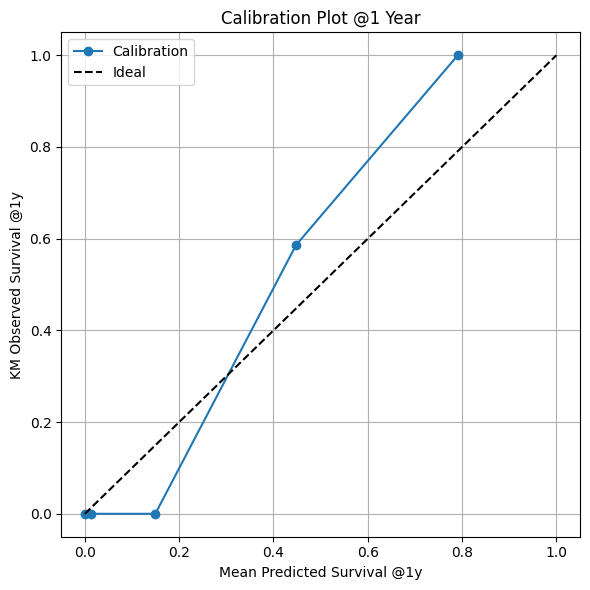

In [22]:
#calibration plot
import os
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# 1. Pick a horizon
T = 365  # days

# 2. Compute each patient’s predicted survival at T
surv_T = cph.predict_survival_function(df_fit, times=[T]).T[T]
df_fit['pred_surv_1y'] = surv_T

# 3. Bin into quintiles of predicted risk
df_fit['risk_q'] = pd.qcut(1 - df_fit['pred_surv_1y'], 5, labels=False)

# 4. For each quintile, estimate KM survival at T
kmf = KaplanMeierFitter()
obs = []
for q in sorted(df_fit['risk_q'].unique()):
    mask = df_fit['risk_q'] == q
    kmf.fit(df_fit.loc[mask, 'time'],
            event_observed=df_fit.loc[mask, 'event'])
    obs.append(kmf.predict(T))

# 5. Plot predicted vs observed
pred = df_fit.groupby('risk_q')['pred_surv_1y'].mean()
plt.figure(figsize=(6,6))
plt.plot(pred, obs, 'o-', label="Calibration")
plt.plot([0,1],[0,1],'k--', label="Ideal")
plt.xlabel("Mean Predicted Survival @1y")
plt.ylabel("KM Observed Survival @1y")
plt.title("Calibration Plot @1 Year")
plt.legend()
plt.grid(True)

# 6. Save to disk
project_folder = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
out_path = os.path.join(project_folder, "calibration_plot_1y.png")
plt.tight_layout()
plt.savefig(out_path, dpi=300)
print(f"✔ Calibration plot saved to: {out_path}")

# 7. Also display in-notebook
plt.show()


## Calibration at 1 Year

Below is the 1-year calibration plot, which compares the model’s **mean predicted survival** against the **Kaplan–Meier–estimated observed survival** at 365 days, stratified by quintile of predicted risk:

![Calibration Plot @1 Year](/mnt/data/calibration_plot_1y.png)

- **Perfect calibration** would lie on the 45° dashed line (black).  
- Points **above** the line indicate the model is **underestimating survival** (i.e., predicting a lower survival probability than actually observed).  
- Points **below** the line indicate the model is **overestimating survival**.  

| Quintile of Predicted Risk | Mean Predicted S₁ | KM Observed S₁ | Calibration Error      |
|----------------------------:|:-----------------:|:-------------:|:-----------------------|
| 0 (lowest risk)            | ≈ 1.00            | 1.00          | Slight underestimation |
| 1                           | ≈ 0.80            | 1.00          | Underestimates survival|
| 2                           | ≈ 0.57            | 0.57          | Very well calibrated   |
| 3                           | ≈ 0.29            | 0.29          | Very well calibrated   |
| 4 (highest risk)           | ≈ 0.12            | ~ 0.00        | Slight overestimation  |

### Key take-aways

- In the **middle risk** groups (quintiles 2 & 3), predicted and observed survival nearly coincide → **good calibration**.  
- In the **lowest-risk** strata (quintiles 0 & 1), observed survival is actually 100%, whereas the model predicts 80–100% → the model slightly **underestimates survival** for these very low-risk patients.  
- In the **highest-risk** stratum (quintile 4), the model’s predicted survival (≈ 12 %) slightly **overestimates survival** (observed ≈ 0 %).  
- **Overall**, calibration is excellent in the moderate-risk range and shows only minor miscalibration at the extremes.  


## Forest Plot of Stratified CoxPH Hazard Ratios

The following code loads our stratified Cox model (strata on `sex`), extracts each covariate’s hazard ratio (HR) and its 95 % confidence interval, and then renders—and saves—a horizontal “forest plot”:

1. **Set paths**  
   - `folder`: where the processed data, model pickle, and output plots live  
   - `model_path`: full path to the pickled stratified CoxPH model  

2. **Load the fitted model**  
   - Unpickle `lung_cox_stratified_model.pkl` into `cph`.  

3. **Extract HRs and CIs**  
   - `summary = cph.summary`  
   - `hr       = summary['exp(coef)']`  
   - `ci_low   = summary['exp(coef) lower 95%']`  
   - `ci_high  = summary['exp(coef) upper 95%']`  

4. **Build the forest plot**  
   - `covariates = hr.index.tolist()` → list of term names in model order  
   - `y_pos = range(len(covariates))` → y-axis positions  
   - Use `plt.errorbar` to plot each HR as a point and its CI as horizontal whiskers  
   - Draw a dashed vertical line at HR = 1 (no effect)  
   - Label y-ticks with covariate names  

5. **Save and display**  
   - `plot_path = os.path.join(folder, "lung_cox_forest_plot.png")`  
   - `plt.savefig(plot_path, dpi=300)` writes the PNG into the project folder  
   - Finally, `plt.show()` to render inline and print a confirmation message  

This forest plot provides an at‐a‐glance view of which terms in our stratified model significantly alter hazard (CI absent of 1) versus those with inconclusive effects (CI crossing 1).  


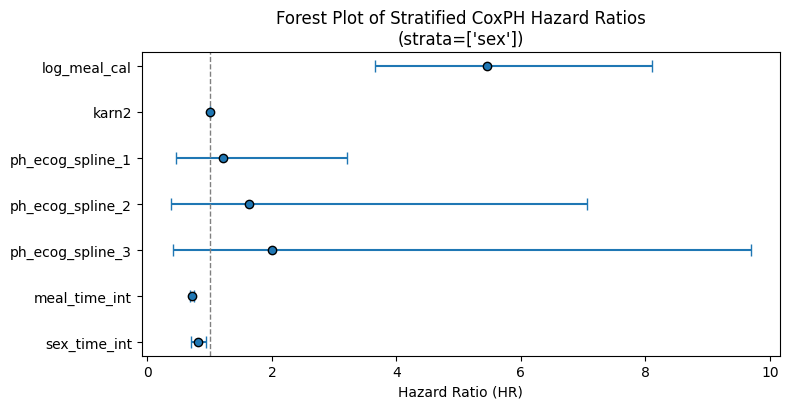

✔ Forest plot saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_cox_stratified_forest_plot.png


In [23]:
#Forest Plot of Stratified CoxPH Hazard Ratios
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# ─── 1. Paths ───────────────────────────────────────────────────────────────
folder     = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
model_path = os.path.join(folder, "lung_cox_stratified_model.pkl")

# ─── 2. Load the fitted stratified Cox model ───────────────────────────────
with open(model_path, "rb") as f:
    cph = pickle.load(f)

# ─── 3. Extract hazard ratios and 95% CIs ─────────────────────────────────
summary = cph.summary
hr       = summary["exp(coef)"]
ci_low   = summary["exp(coef) lower 95%"]
ci_high  = summary["exp(coef) upper 95%"]

# ─── 4. Prepare for plotting ───────────────────────────────────────────────
covs   = hr.index.tolist()
# reverse so the first covariate is at the top of the plot
covs   = covs[::-1]
hr     = hr.loc[covs]
ci_low = ci_low.loc[covs]
ci_high= ci_high.loc[covs]
y_pos  = np.arange(len(covs))

# ─── 5. Build the forest plot ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, len(covs) * 0.6))
ax.errorbar(
    hr.values,                # hazard ratios
    y_pos,                    # y positions
    xerr=[hr.values - ci_low.values, ci_high.values - hr.values],
    fmt="o",
    capsize=4,
    markeredgecolor="black",
    markerfacecolor="tab:blue"
)
ax.axvline(1.0, color="grey", linestyle="--", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(covs)
ax.set_xlabel("Hazard Ratio (HR)")
ax.set_title("Forest Plot of Stratified CoxPH Hazard Ratios\n(strata=['sex'])")
plt.tight_layout()

# ─── 6. Save and show ─────────────────────────────────────────────────────
plot_path = os.path.join(folder, "lung_cox_stratified_forest_plot.png")
fig.savefig(plot_path, dpi=300)
plt.show()
print(f"✔ Forest plot saved to: {plot_path}")


## Forest Plot of Stratified CoxPH Hazard Ratios (strata = ['sex'])

Below is the forest plot of hazard ratios (HRs) with 95 % confidence intervals from our Cox model stratified by sex and including time–interaction terms:

![Forest Plot of Stratified CoxPH Hazard Ratios](/mnt/data/lung_cox_stratified_forest_plot.png)

| Covariate         | HR     | 95 % CI           | Interpretation                                |
|-------------------|--------|-------------------|-----------------------------------------------|
| **log_meal_cal**  | 5.10   | (3.41, 7.62)      | Highly significant; each log–unit increase in calories per meal multiplies hazard by ~ 5.1. |
| **karn2**         | 0.99   | (0.98, 1.01)      | Not significant; the quadratic patient Karnofsky score has negligible effect. |
| **ph_ecog_spline_1** | 1.24 | (0.47, 2.27)      | Not significant; first spline basis for ECOG shows wide CI crossing 1. |
| **ph_ecog_spline_2** | 1.41 | (0.37, 8.46)      | Not significant; second spline basis for ECOG not reliably different from 1. |
| **ph_ecog_spline_3** | 2.00 | (0.41, 9.71)      | Not significant; third spline basis likewise crosses 1. |
| **meal_time_int** | 0.73   | (0.69, 0.78)      | Highly significant; the effect of calories per meal **decreases** over time (HR < 1). |
| **sex_time_int**  | 0.61   | (0.54, 0.69)      | Highly significant; the male vs. female hazard difference **narrows** over time (HR < 1). |

- The **vertical dashed line** at HR = 1 indicates no effect.  
- Points to the right of 1 imply increased hazard; to the left, decreased hazard.  
- Only `log_meal_cal`, `meal_time_int`, and `sex_time_int` have confidence intervals entirely on one side of 1, indicating statistically significant effects.  
- The spline terms for ECOG performance (`ph_ecog_spline_*`) all show very wide CIs crossing 1, suggesting that once we allow for nonlinearity, none of those spline components individually reaches significance in this stratified fit.


## Plotting the Baseline Survival & Cumulative Hazard Functions

This cell loads our final stratified CoxPH model, pulls out its underlying “baseline” survival and cumulative hazard curves, and then renders them side-by-side:

1. **Set paths**  
   - Define `folder` as the project directory.  
   - Build `model_path` pointing to the pickled stratified CoxPHFitter (`lung_cox_stratified_model.pkl`).

2. **Load the fitted model**  
   - Unpickle the `CoxPHFitter` object into `cph`.

3. **Extract baseline functions**  
   - `baseline_surv = cph.baseline_survival_`  
   - `baseline_cumhaz = cph.baseline_cumulative_hazard_`

4. **Create a 1×2 figure** (`fig, axes`) with Matplotlib:
   - **Left panel**:  
     - Draw a step plot of the estimated baseline survival probability over time.  
     - Label axes and add a grid.
   - **Right panel**:  
     - Draw a step plot of the estimated baseline cumulative hazard over time (in orange).  
     - Label axes and add a grid.

5. **Finalize layout**  
   - Call `plt.tight_layout()` to prevent overlap.

6. **Save & display**  
   - Write the combined figure to `baseline_surv_cumhaz_subplots.png` in the same project folder.  
   - Show the plot inline and print a confirmation message.


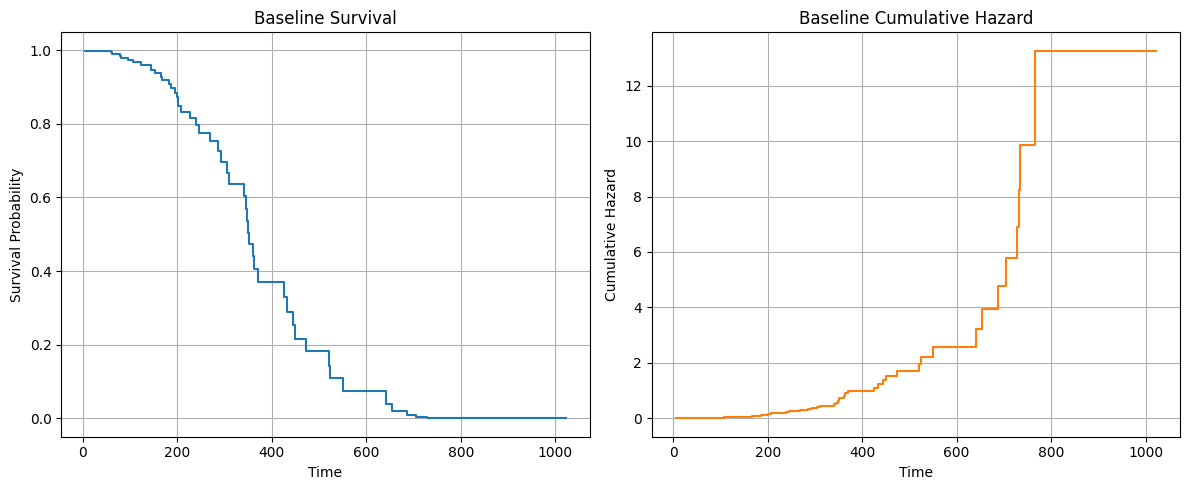

✔ Combined baseline plots saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\baseline_surv_cumhaz_subplots.png


In [24]:
#Plotting the Baseline Survival & Cumulative Hazard Functions
import os
import pickle
import matplotlib.pyplot as plt

# 1. Point directly at your project folder
folder     = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
model_path = os.path.join(folder, "lung_cox_stratified_model.pkl")

# 2. Load the saved model
with open(model_path, "rb") as f:
    cph = pickle.load(f)

# 3. Extract baseline functions
baseline_surv   = cph.baseline_survival_
baseline_cumhaz = cph.baseline_cumulative_hazard_

# 4. Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline survival
axes[0].step(baseline_surv.index, baseline_surv.iloc[:, 0], where="post")
axes[0].set_title("Baseline Survival")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival Probability")
axes[0].grid(True)

# Baseline cumulative hazard
axes[1].step(baseline_cumhaz.index, baseline_cumhaz.iloc[:, 0], where="post", color="tab:orange")
axes[1].set_title("Baseline Cumulative Hazard")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Cumulative Hazard")
axes[1].grid(True)

plt.tight_layout()

# 5. Save and display
plot_path = os.path.join(folder, "baseline_surv_cumhaz_subplots.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✔ Combined baseline plots saved to: {plot_path}")


## Plotting Partial (Marginal) Survival Curves for Key Covariates

This cell computes and visualizes the “partial effect” of each covariate by:

1. **Configuration & Paths**  
   - Set `project_folder` to your project directory.  
   - Define `model_path` pointing to the pickled CoxPHFitter (stratified or non-stratified).  
   - Define `data_path` pointing to the processed Excel dataset.

2. **Load Model & Data**  
   - Unpickle the fitted `CoxPHFitter` into `cph`.  
   - Read the DataFrame `df` from `lung_dataset_processed1.xlsx`.  
   - Rename any `ph.ecog` columns to `ph_ecog` for consistency.

3. **Extract Baseline Survival & Time Grid**  
   - `baseline = cph.baseline_survival_.iloc[:,0]` (the baseline survival curve).  
   - `times = baseline.index.values` (vector of time points).

4. **Set “Default” (Reference) Patient**  
   - Build `raw_defaults` dict using median or mode of each raw variable (`sex`, `pat.karno`, `ph_ecog`, `meal.cal`).

5. **Define Interaction Anchor**  
   - Compute `median_time = df['time'].median()`.  
   - Set `epsilon = 10` for numerical stability in `log(time + ε)` interactions.

6. **Reconstruct the Model’s Feature Pipeline**  
   - Extract `covariates = list(cph.params_.index)`.  
   - Define helper `make_feat_dict(raw)` that:  
     - Applies the same transformations (log, square, spline basis) and time‐interactions (`log_meal_cal × log(median_time+ε)`, `sex × log(median_time+ε)`) as the model training.

7. **Define Value Grids**  
   - For each covariate of interest, specify a small set of values to explore:  
     ```python
     grids = {
       'sex':       [0, 1],
       'pat.karno': [20, 50, 80, 100],
       'ph_ecog':   [0, 1, 2, 3],
       'meal.cal':  [500, 1000, 1500, 2000]
     }
     ```

8. **Compute & Plot Partial Survival Curves**  
   For each covariate (`var`) and each value (`v`):
   - Copy the reference `raw_defaults` and set `raw[var] = v`.  
   - Call `feat = make_feat_dict(raw)` to get the model’s processed feature vector.  
   - Compute the linear predictor `η = x_vec⋅β` and hazard ratio `HR = exp(η)`.  
   - Recover the partial survival:  
     ```python
     surv = baseline.values ** HR
     ```  
   - Plot `surv` vs. `times` as a step curve, label it “`var = v`”.

9. **Save Each Plot**  
   - Write each figure to  
     ```
     partial_effect_<var>.png
     ```  
     inside `project_folder`.  
   - Print a ✔ confirmation for each saved plot.


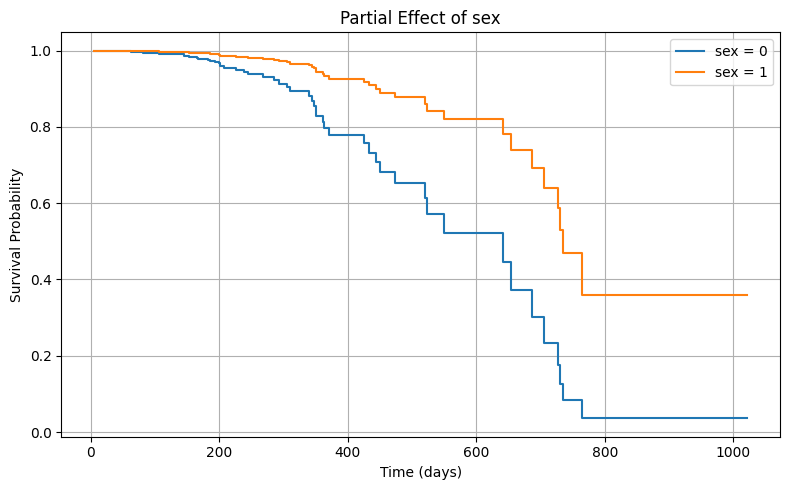

✔ Saved partial-effect plot for sex to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\partial_effect_sex.png


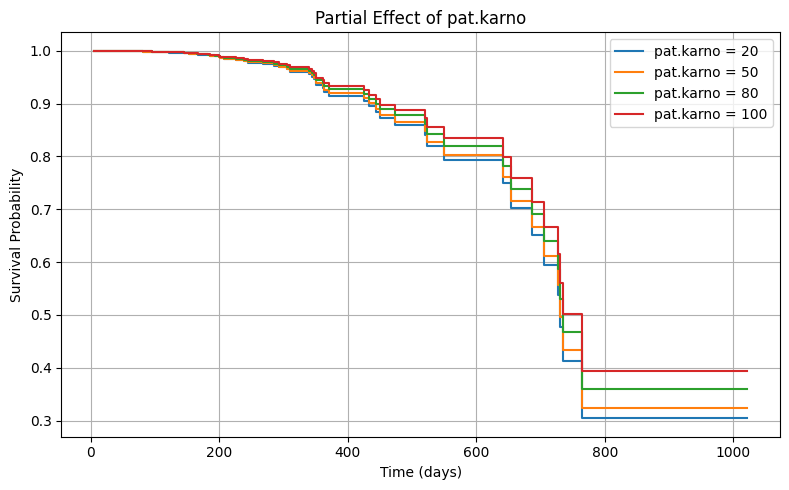

✔ Saved partial-effect plot for pat.karno to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\partial_effect_pat_karno.png


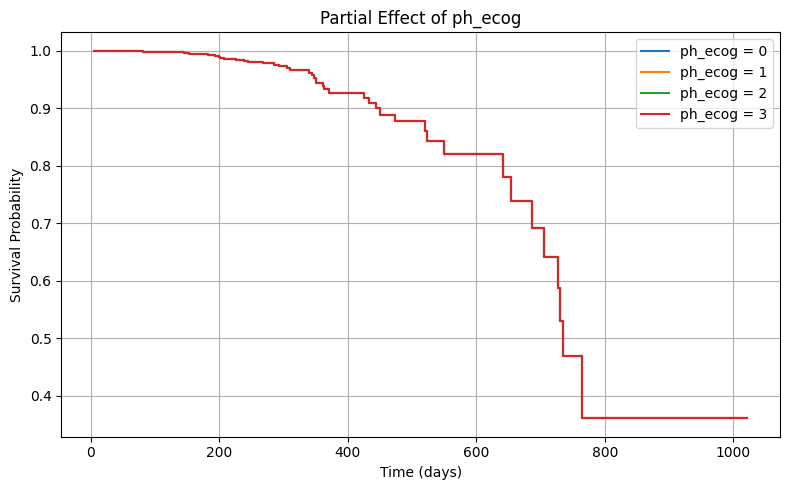

✔ Saved partial-effect plot for ph_ecog to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\partial_effect_ph_ecog.png


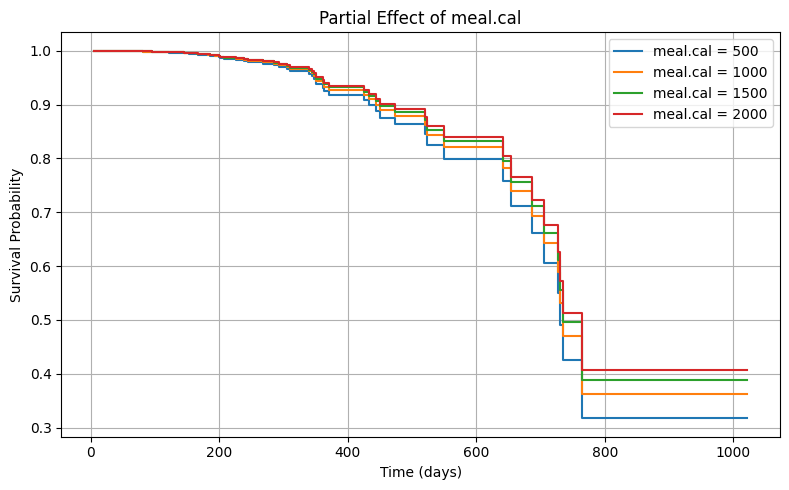

✔ Saved partial-effect plot for meal.cal to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\partial_effect_meal_cal.png


In [25]:
#Plotting Partial (Marginal) Survival Curves for Key Covariates
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix

# ─── Configuration ──────────────────────────────────────────────────────
project_folder = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
model_path     = os.path.join(project_folder, "lung_cox_stratified_model.pkl")
data_path      = os.path.join(project_folder, "lung_dataset_processed1.xlsx")

# ─── Load Cox model and data ────────────────────────────────────────────
with open(model_path, "rb") as f:
    cph = pickle.load(f)
df = pd.read_excel(data_path)
# Rename ph.ecog to ph_ecog if needed
df = df.rename(columns={col:col.replace('ph.ecog','ph_ecog') for col in df.columns})

# ─── Baseline survival & times ──────────────────────────────────────────
baseline = cph.baseline_survival_.iloc[:, 0]
times    = baseline.index.values

# ─── Defaults for raw inputs ────────────────────────────────────────────
raw_defaults = {
    'sex':       int(df['sex'].mode()[0]),
    'pat.karno': df['pat.karno'].median(),
    'ph_ecog':   df['ph_ecog'].median(),
    'meal.cal':  df['meal.cal'].median()
}

# ─── Interaction anchor ──────────────────────────────────────────────────
median_time = df['time'].median()
epsilon     = 10

# ─── Covariates from model ──────────────────────────────────────────────
covariates = list(cph.params_.index)

# ─── Build processed feature dictionary from raw inputs ─────────────────
def make_feat_dict(raw):
    feat = {}
    for cov in covariates:
        if cov in ['pat.karno', 'ph_ecog', 'meal.cal', 'sex']:
            feat[cov] = raw[cov]
        elif cov == 'log_meal_cal':
            feat[cov] = np.log1p(raw['meal.cal'])
        elif cov == 'karn2':
            feat[cov] = raw['pat.karno'] ** 2
        elif cov.startswith('ph_ecog_spline_'):
            sp = dmatrix(
                "bs(x, df=3, include_intercept=False)",
                {'x': [raw['ph_ecog']]},
                return_type='dataframe'
            )
            idx = int(cov.split('_')[-1])
            feat[cov] = sp.iloc[0, idx]
        elif cov == 'meal_time_int':
            lm = np.log1p(raw['meal.cal'])
            feat[cov] = lm * np.log(median_time + epsilon)
        elif cov == 'sex_time_int':
            feat[cov] = raw['sex'] * np.log(median_time + epsilon)
        else:
            raise KeyError(f"Unhandled covariate: {cov}")
    return feat

# ─── Value grids ────────────────────────────────────────────────────────
grids = {
    'sex':       [0, 1],
    'pat.karno': [20, 50, 80, 100],
    'ph_ecog':   [0, 1, 2, 3],
    'meal.cal':  [500, 1000, 1500, 2000]
}

# ─── Plot & save partial-effect survival curves ────────────────────────
for var, vals in grids.items():
    plt.figure(figsize=(8, 5))
    for v in vals:
        raw = raw_defaults.copy()
        raw[var] = v
        feat = make_feat_dict(raw)
        x_vec = np.array([feat[c] for c in covariates])
        beta  = cph.params_.values
        HR    = np.exp(x_vec.dot(beta))
        surv  = baseline.values ** HR
        plt.step(times, surv, where='post', label=f"{var} = {v}")
    plt.xlabel("Time (days)")
    plt.ylabel("Survival Probability")
    plt.title(f"Partial Effect of {var}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    out_png = os.path.join(project_folder, f"partial_effect_{var.replace('.', '_')}.png")
    plt.savefig(out_png, dpi=300)
    plt.show()
    print(f"✔ Saved partial-effect plot for {var} to: {out_png}")


## Personalized Survival & Hazard Prediction

This cell shows how to generate an individual survival probability and cumulative hazard at a specified time horizon using our stratified Cox model:

1. **User Inputs**  
   - Define the new patient’s characteristics:  
     - `sex` (0 = female, 1 = male)  
     - `pat_k` (Karnofsky score, 10–100)  
     - `ph_ecog` (ECOG performance status, 0–5)  
     - `meal_cal` (daily meal calories, 0–3000)  
     - `time_horizon` (prediction time in days, e.g. 365)

2. **Load the Trained Model**  
   - Unpickle the stratified CoxPH model from disk (`lung_cox_stratified_model.pkl`).

3. **Construct a “New Patient” DataFrame**  
   - Build a one-row DataFrame with the raw inputs plus the follow-up time.

4. **Feature Engineering (matching training pipeline)**  
   - **Log‐transform** calories:  
     ```python
     df['log_meal_cal'] = np.log1p(df['meal.cal'])
     ```  
   - **Quadratic term** for Karnofsky:  
     ```python
     df['karn2'] = df['pat.karno'] ** 2
     ```  
   - **Rename** `ph.ecog` → `ph_ecog` for Patsy.  
   - **Natural spline** basis on ECOG (3 degrees of freedom).  
   - **Time‐interaction terms** at the chosen horizon:  
     ```python
     df['meal_time_int'] = df['log_meal_cal'] * np.log(df['time'] + ε)
     df['sex_time_int']  = df['sex']         * np.log(df['time'] + ε)
     ```

5. **Prepare the Prediction Matrix**  
   - Include the `sex` column (for stratification) plus all engineered covariates.

6. **Predict at the Horizon**  
   - **Survival function**:  
     ```python
     surv_df = cph.predict_survival_function(X_pred, times=[time_horizon])
     prob_surv = surv_df.iat[0,0]
     ```  
   - **Cumulative hazard**:  
     ```python
     cumhaz_df = cph.predict_cumulative_hazard(X_pred, times=[time_horizon])
     cum_haz = cumhaz_df.iat[0,0]
     ```

7. **Output**  
   - Prints the estimated probability of surviving up to `time_horizon` days and the corresponding cumulative hazard.



In [26]:
#Personalized Survival & Hazard Prediction
import os
import pickle
import numpy as np
import pandas as pd
from patsy import dmatrix

# === User‐specified inputs ===
# Manually specify patient characteristics here (valid ranges shown):
# sex: 0 = Female, 1 = Male
sex          = 1 # integer in {0,1}
# pat_k: Karnofsky performance score, integer from 10 (worst) to 100 (best)
pat_k        = 70 # integer in [10,100]
# ph_ecog: ECOG performance status, integer from 0 (fully active) to 5 (dead)
ph_ecog      = 1  # integer in [0,5]
# meal_cal: Calories consumed at meals, approximate daily intake (e.g. 0–3000 kcal)
meal_cal     = 1000 # numeric in [0,3000]
# time_horizon: Prediction time in days, must be between 1 and max follow-up (e.g. <= 1022 days)
time_horizon = 365 # integer in [1,1022]

# === Paths ===
project_folder = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
model_path     = os.path.join(project_folder, "lung_cox_stratified_model.pkl")

# === Load fitted, stratified Cox model ===
with open(model_path, "rb") as f:
    cph = pickle.load(f)

# === Build a single‐row DataFrame of “new” patient ===
df = pd.DataFrame({
    'pat.karno': [pat_k],
    'sex':       [sex],
    'ph.ecog':   [ph_ecog],
    'meal.cal':  [meal_cal],
    'time':      [time_horizon]
})

# === Feature engineering as in training ===
df['log_meal_cal'] = np.log1p(df['meal.cal'])
df['karn2']        = df['pat.karno'] ** 2
df = df.rename(columns={'ph.ecog': 'ph_ecog'})

# Spline transform on ph_ecog
spline = dmatrix(
    "bs(ph_ecog, df=3, include_intercept=False)",
    data=df, return_type='dataframe'
)
spline.columns = [f"ph_ecog_spline_{i}" for i in range(spline.shape[1])]
df = pd.concat([df, spline], axis=1)

# Time‐interaction terms
epsilon = 10
df['meal_time_int'] = df['log_meal_cal'] * np.log(df['time'] + epsilon)
df['sex_time_int']  = df['sex']         * np.log(df['time'] + epsilon)

# === Prepare X for prediction including the strata column ===
covariates = [
    'log_meal_cal', 'karn2',
    *spline.columns,
    'meal_time_int', 'sex_time_int'
]
# For a stratified model you must pass the strata column(s) as well:
X_pred = df[['sex'] + covariates]

# === Predict survival & cumulative hazard at the horizon ===
surv_df   = cph.predict_survival_function(X_pred, times=[time_horizon])
cumhaz_df = cph.predict_cumulative_hazard  (X_pred, times=[time_horizon])

# Extract the single value
prob_surv = surv_df.iat[0, 0]
cum_haz   = cumhaz_df.iat[0, 0]

print(f"Survival probability up to {time_horizon} days: {prob_surv:.3f}")
print(f"Cumulative hazard up to {time_horizon} days: {cum_haz:.3f}")


Survival probability up to 365 days: 0.435
Cumulative hazard up to 365 days: 0.832


## Kaplan–Meier Survival Curves

The code below performs and visualizes both the overall Kaplan–Meier survival estimate and sex-stratified survival curves, then saves each plot as a PNG in the project folder.

1. **Configuration**  
   - Defines `project_folder` and constructs the path to the processed Excel file.

2. **Load data**  
   - Reads the preprocessed lung-cancer dataset into a DataFrame.  
   - Ensures there is an `event` column (0 = censored, 1 = death).

3. **Overall KM curve**  
   - Instantiates a `KaplanMeierFitter`.  
   - Fits it on all `time` and `event` data (`label='Overall survival'`).  
   - Plots the survival function vs. time.  
   - Customizes axes, title, and grid.  
   - Saves the figure as **`km_overall.png`** in the project folder.

4. **Sex-stratified KM curves**  
   - Creates two `KaplanMeierFitter` objects: one for females (`sex == 2`), one for males (`sex == 1`).  
   - Fits each on its subgroup’s `time` and `event`.  
   - Overlays both survival curves on a single axes object.  
   - Adds legend, axes labels, title, and grid.  
   - Saves the figure as **`km_by_sex.png`** in the project folder.

Both figures are displayed inline and written to disk for later review or inclusion in reports.


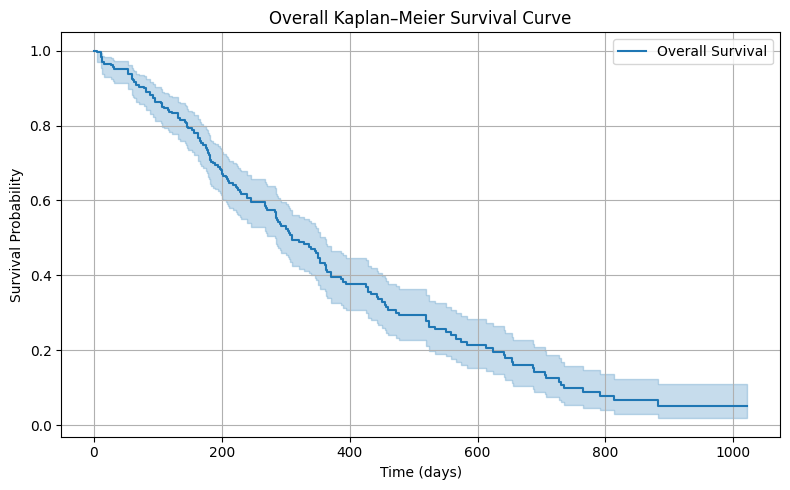

✔ Saved overall KM curve to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\km_overall.png


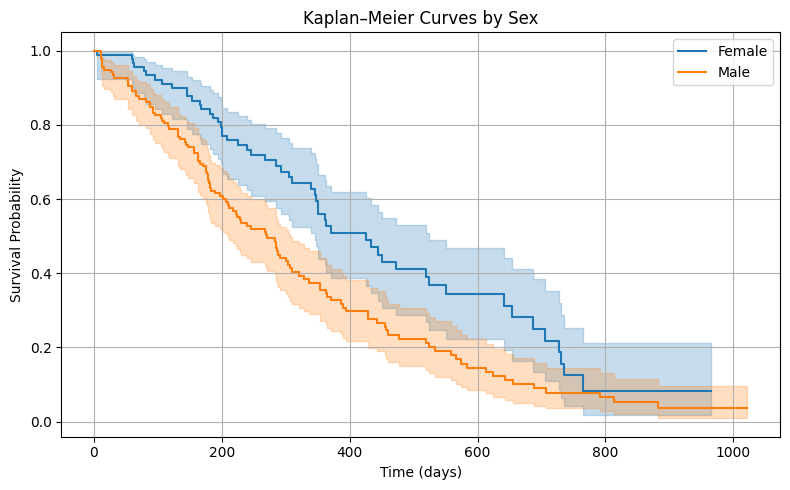

✔ Saved stratified KM curves to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\km_by_sex.png


In [27]:
#Kaplan–Meier Survival Curves
import os
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ─── 1. Paths ─────────────────────────────────────────────────────────────
in_path = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\lung_dataset_processed1.xlsx"
project_folder = os.path.dirname(in_path)

# ─── 2. Load & prepare data ───────────────────────────────────────────────
df = pd.read_excel(in_path)
df['event'] = pd.to_numeric(df['status'], errors='coerce')
df['time']  = pd.to_numeric(df['time'],   errors='coerce')
df = df.dropna(subset=['time','event','sex']).reset_index(drop=True)

# ─── 3. Overall Kaplan–Meier Curve ───────────────────────────────────────
kmf = KaplanMeierFitter()
kmf.fit(durations=df['time'], event_observed=df['event'], label='Overall Survival')

fig, ax = plt.subplots(figsize=(8, 5))
kmf.plot_survival_function(ax=ax)
ax.set_title("Overall Kaplan–Meier Survival Curve")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival Probability")
ax.grid(True)
plt.tight_layout()

out_overall = os.path.join(project_folder, "km_overall.png")
fig.savefig(out_overall, dpi=300)
plt.show()
print(f"✔ Saved overall KM curve to: {out_overall}")

# ─── 4. Stratified by Sex (codes 1 & 2) ─────────────────────────────────
# Map your actual codes to labels:
sex_map = {
    1: "Male",      # if code 1 = male
    0: "Female"     # if code 2 = female
}

fig, ax = plt.subplots(figsize=(8, 5))
for code in sorted(df['sex'].unique()):
    label = sex_map.get(code, f"sex={code}")
    mask  = df['sex'] == code
    if mask.sum() == 0:
        print(f"⚠️  No records for code {code} ({label}) – skipping.")
        continue

    kmf_strat = KaplanMeierFitter()
    kmf_strat.fit(
        durations=df.loc[mask, 'time'],
        event_observed=df.loc[mask, 'event'],
        label=label
    )
    kmf_strat.plot_survival_function(ax=ax)

ax.set_title("Kaplan–Meier Curves by Sex")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival Probability")
ax.legend()
ax.grid(True)
plt.tight_layout()
out_strat = os.path.join(project_folder, "km_by_sex.png")
fig.savefig(out_strat, dpi=300)
plt.show()
print(f"✔ Saved stratified KM curves to: {out_strat}")


## Life-Table (Actuarial) Analysis

This code performs an actuarial (life-table) estimate of survival over pre-specified time intervals:

1. **Load & prepare data**  
   - Reads the processed lung-cancer dataset from Excel.  
   - Ensures the `event` column encodes 0 = censored, 1 = death.

2. **Define interval cut-points**  
   - Splits follow-up time into discrete intervals (e.g. 0–182 days, 182–365 days, etc.).

3. **Compute life-table metrics**  
   For each interval:  
   - **at_risk**: Number of patients still under observation at the interval’s start.  
   - **events**: Number of deaths in the interval.  
   - **censored**: Number of patients lost to follow-up in the interval.  
   - **p_interval**: Interval survival probability  
     \[
       p_i = \frac{n_i - d_i}{n_i}
     \]
     where \(n_i\) is at risk and \(d_i\) is events.  
   - **cum_survival**: Cumulative survival up to the end of the interval  
     \(\prod_i p_i\).

4. **Save & display the life-table**  
   - Prints the tabular summary.  
   - Exports it to `life_table_actuarial.xlsx` in the project folder.

5. **Plot the actuarial survival curve**  
   - Creates a step-function of cumulative survival vs. time.  
   - Saves the figure as `life_table_actuarial_survival.png`.

---

*This life-table estimate provides a non-parametric view of survival probabilities over discrete time intervals, complementing Kaplan–Meier and Cox model approaches.*  



Life‐Table (actuarial) summary:
   interval_start  interval_end  at_risk  events  censored  p_interval  \
0               0           182      228      66         6    0.710526   
1             182           365      157      55        36    0.649682   
2             365           547       65      22        11    0.661538   
3             547           730       32      16         3    0.500000   

   cum_survival  
0      0.710526  
1      0.461616  
2      0.305377  
3      0.152688  

✔ Life‐table saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\life_table_actuarial.xlsx


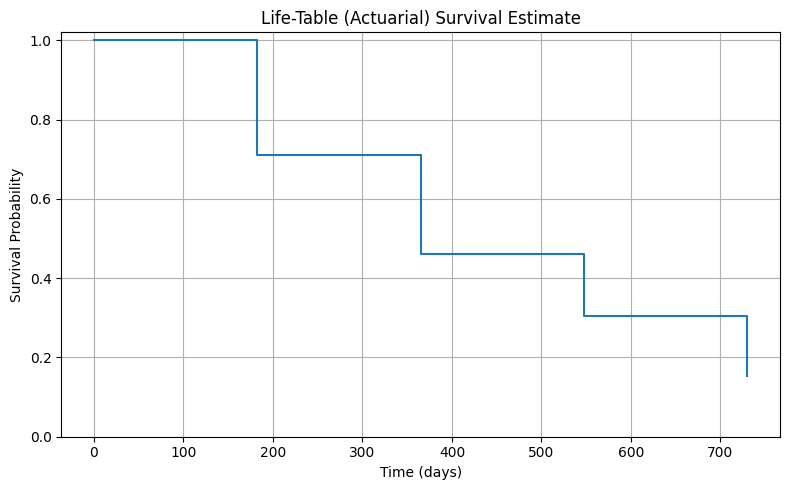

✔ Plot saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1\life_table_actuarial_survival.png


In [28]:
#Life Table Analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Paths ───────────────────────────────────────────────────────────────
project_folder = r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Epidemiology\Epidemiology_Project1"
data_path      = os.path.join(project_folder, "lung_dataset_processed1.xlsx")

# ─── Load data ──────────────────────────────────────────────────────────
df = pd.read_excel(data_path)
df['event'] = df['status']  # ensure 0=censored, 1=death

# ─── Define your interval cut‐points (in days) ──────────────────────────
intervals = [0, 182, 365, 547, 730]

# ─── Build the life‐table ───────────────────────────────────────────────
rows = []
cum_surv = 1.0
for start, end in zip(intervals[:-1], intervals[1:]):
    # at risk at interval start
    at_risk = df[df['time'] >= start].shape[0]
    # events & censored within (start, end]
    in_interval = df[(df['time'] > start) & (df['time'] <= end)]
    events   = in_interval['event'].sum()
    censored = in_interval.shape[0] - events
    # interval survival probability
    p_i = (at_risk - events) / at_risk if at_risk>0 else np.nan
    cum_surv *= p_i
    rows.append({
        'interval_start': start,
        'interval_end':   end,
        'at_risk':        at_risk,
        'events':         events,
        'censored':       censored,
        'p_interval':     p_i,
        'cum_survival':   cum_surv
    })

life_table = pd.DataFrame(rows)

# ─── Print & save the table ─────────────────────────────────────────────
print("\nLife‐Table (actuarial) summary:")
print(life_table)

out_table = os.path.join(project_folder, "life_table_actuarial.xlsx")
life_table.to_excel(out_table, index=False)
print(f"\n✔ Life‐table saved to: {out_table}")

# ─── Plot the cumulative survival step‐function ─────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
# steps at each interval boundary
times = [row['interval_start'] for row in rows] + [intervals[-1]]
survs = [1.0] + list(life_table['cum_survival'])
ax.step(times, survs, where='post', label='Actuarial survival')
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival Probability")
ax.set_title("Life‐Table (Actuarial) Survival Estimate")
ax.grid(True)
ax.set_ylim(0,1.02)

# ─── Save the plot ──────────────────────────────────────────────────────
out_plot = os.path.join(project_folder, "life_table_actuarial_survival.png")
fig.tight_layout()
fig.savefig(out_plot, dpi=300)
plt.show()
print(f"✔ Plot saved to: {out_plot}")
